# Segmentez des clients d'un site e-commerce

- **Projet 5 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**

## Partie 2 : Essais de modélisation

<img  width="76" height="30" src="./brand.svg" alt="Logo olist">


# 1. Compréhension du problème

## 1.1 Mission

[Olist](https://olist.com/), une entreprise brésilienne qui propose une solution de vente sur les
marketplaces en ligne, souhaite une **segmentation des clients** que ses équipes d'e-commerce pourront
utiliser au quotidien pour leurs campagnes de communication.

- **comprendre les différents types d'utilisateurs**, grâce à leur comportement et à leurs données
  personnelles, en regroupant des clients de profils similaires. Ces catégories pourront être
  utilisées par l’équipe Marketing pour mieux communiquer.

- **fournir à l’équipe marketing une description actionable** de votre segmentation et de sa logique
  sous-jacente pour une utilisation optimale

- **une proposition de contrat de maintenance**, (fréquence à laquelle la segmentation doit être
  mise à jour pour rester pertinente), basée sur une analyse de la stabilité des segments au cours
  du temps.


## 1.2 Requirements : Bibliothèques utilisées dans ce notebook

- voir [`requirements.txt`](./requirements.txt) pour les versions des bibliothèques testées avec ce notebook


In [1]:
# si ce notebook ne marche pas avec les versions
# des bibliothèques dans votre environnement, alors
# de-commentarise la ligne suivant pour des versions testées :

# %pip install -r requirements.txt


In [2]:
def install_libraries(required=None) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas', 'matplotlib', 'seaborn',
                      'scipy', 'scikit-learn', 'statsmodels',
                      'missingno', 'dython', 'squarify', 'yellowbrick', 'plotly'}
install_libraries(required_libraries)


### 1.2.1 Import des bibliothèques


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import sklearn
import dython
import squarify
import yellowbrick
import plotly.express as px
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# pour calculer VIF -Variance Influence Factor
# correlations catégoriques (Cramers V, Theils U)


### 1.2.2 Liste des versions des bibliothèques utilisées


In [4]:
from platform import python_version

python_version()
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))


versions des bibliothèques utilisées:
numpy==1.21.5; pandas==1.1.5; seaborn==0.11.2; scipy==1.7.3; sklearn==1.0.2; dython==0.6.8; yellowbrick==1.4


### 1.2.3 Configuration défauts d'affichage


In [5]:
from sklearn import set_config
pd.set_option('display.max_columns', 200)  # pour afficher toutes les colonnes
pd.set_option('display.max_rows', 20)  # pour afficher max 10 lignes
pd.set_option('display.max_colwidth', 800)  # pour afficher toutes la text
pd.set_option('display.precision', 2)
pd.options.display.float_format = '{:.2f}'.format  # currency, lat,lng

%matplotlib inline
sns.set_theme(style="white", context="notebook")
sns.set_color_codes("pastel")
sns.set_palette("tab20")

set_config(display='diagram')
# displays HTML representation in a jupyter context


## 1.3 Des fonctions utilitaires

### 1.3.1 Enregistrement des graphiques

Pour enregistrer les graphiques, define **`SAVE_IMAGES = True`**


In [6]:
SAVE_IMAGES = True
IMAGE_FOLDER = './images/notebook'
if not os.path.exists(IMAGE_FOLDER):
    os.makedirs(IMAGE_FOLDER)


In [7]:
def to_png(fig_name=None) -> None:
    """
    Enregistre l'image dans un fichier,
    il faut appeler avant plt.show() pour pouvoir ajuster la taille de l'image
    avec bbox_inches=tight pour être sûr d'inclure le titre / legend entier.
    """

    def get_title():
        if plt.gcf()._suptitle is None:  # noqa
            return plt.gca().get_title()
        else:
            return plt.gcf()._suptitle.get_text()  # noqa

    if SAVE_IMAGES:
        if fig_name is None:
            fig_name = get_title()
        elif len(fig_name) < 9:
            fig_name = f'{fig_name}_{get_title()}'
        fig_name = fig_name.replace(' ', '_').replace(':', '-').replace(
            '.', '-').replace('/', '_').replace('>', 'gt.').replace('<', 'lt.')
        print(f'"{fig_name}.png"')
        plt.gcf().savefig(
            f'{IMAGE_FOLDER}/{fig_name}.png', bbox_inches='tight')


### 1.3.2 Vérifier que les colonnes sont dans le dataframe

- sans changer l'ordre des colonnes


In [8]:
def cols_in_df(df: pd.DataFrame, colonnes: list = None) -> list:
    """Procedure pour retourner les colonnes existantes dans le dataframe dans la même ordre.
    Utiliser pour assurer que les colonnes existe.
    """
    ret_cols = []
    for col in colonnes:
        if col in df.columns:
            ret_cols.append(col)
    return ret_cols


### Quelque constants


In [9]:
# Set random_state pour reproduire les resultats
# Pour des resultats différents sur chaque execution, set RANDOM_SEED=None
RANDOM_SEED = 0

# colonne qui reçoive les labels des clusters produit par la classification
CLUSTER_COL = 'cluster_id'

# colonne qui reçoive les pourcentages dans chaque cluster apres df.groupby(CLUSTER_COL)
# ou df[CLUSTER_COL].value_counts(normalize=True)
CLUSTER_PCT = 'cluster_pct'

# colonne pour ordonner les clusters (s'il est present), avant d'afficher en graphique
VALUE_COL = 'MonetaryValue'

# palette de couleurs pour les plots des clusters
# (pour d'autres graphiques on utilise tab10/tab20)
CLUSTER_PALETTE = 'nipy_spectral'


### Note sur les variables

#### Les données

- **df_clients** : data.groupby(unique_customer_id) - on ne modifie pas

#### Les preprocessors

- **preprocessor_XXX** : pipeline de preprocessing

#### Pour chaque essai (N)

- **N** : un nombre ou un abbreviation comme _RFM_, _Kmeans_, _CAH_ etc :
- **ESSAI_N** : titre d'un essai
- **features_N** : les features choisis pour un essai
- **model_N** : le model pour l'essai, composé de preprocessor_XXX et un classifier
- **df_clusters_N** : un dataframe avec 'unique_customer_id' comme index,
  contenant au moins le cluster_id dans colonne CLUSTER_COL
- **df_segmentation_N** : un dataframe avec aggregations par cluster_id

#### Variables temporaires

- **df_scores** : scores pour plusieurs essais d'un model


# Essai 1 - Segmentation RFM

Pour établir des segments de clients homogènes, la [segmentation RFM](https://www.definitions-marketing.com/definition/segmentation-rfm/) prend en compte :

- la **Récence** (date de la dernière commande) ;
- la **Fréquence** des commandes ; et
- le **Montant** (de la dernière commande ou moyenne sur une période donnée)

_La segmentation RFM permet de cibler les offres, d'établir des segments basés sur la valeur des clients et de prévenir l'attrition en identifiant des segments à risque._ ([source](https://www.definitions-marketing.com/definition/segmentation-rfm/))


In [10]:
OUT_DIR = 'data/out'
df_clients = pd.read_csv(f'{OUT_DIR}/clients.csv')
df_clients = df_clients.sample(10000,random_state=RANDOM_SEED)
df_clients.head()


customer_unique_id        dernier_achat  Frequency  \
6819   12ba47b187be381c7641afec16c37062  2017-10-13 11:05:58          1   
45112  7c53991e7f6d632c391c6d96809ecd45  2017-05-23 23:13:40          1   
42111  740075865af950b7f052f3cd7303241c  2017-10-31 13:15:31          1   
17957  316c893962c40dfcff2f2fdec409610f  2018-01-18 23:19:22          1   
76479  d2caf4729e0ae98d5c19e9173ee29e24  2017-06-30 12:20:48          1   

       MonetaryValue  Recency  mean_nb_payments  review_score  delivery_time  \
6819           57.77      369              1.00          5.00           5.00   
45112          61.05      511              6.00          5.00          13.00   
42111          41.29      351              1.00          2.00          17.00   
17957         351.99      271              8.00          5.00          13.00   
76479          86.95      474              2.00          5.00          12.00   

       delivery_delay  distance_customer_seller  freight_percent payment_mode  \
6819            -6.00                     14.35             0.13  credit_card   
45112          -14.00                    626.78             0.25  credit_card   
42111          -10.00                   1761.28             0.41  credit_card   
17957          -14.00                    835.07             0.05  credit_card   
76479          -21.00                   1700.72             0.31  credit_card   

      favourite_category  time_of_day  weekday  products_per_order  
6819             fashion        11.00     4.00                1.00  
45112           bed_bath        23.00     1.00                1.00  
42111            leisure        13.00     1.00                1.00  
17957      gifts_gadgets        23.00     3.00                1.00  
76479            leisure        12.00     4.00                1.00

In [11]:
FEATURES_RFM = ['Recency', 'Frequency', 'MonetaryValue']
df_clients[FEATURES_RFM].quantile(q=[0.25, 0.5, 0.75])


Recency  Frequency  MonetaryValue
0.25   162.00       1.00          62.02
0.50   266.00       1.00         106.29
0.75   390.25       1.00         178.76

On voit un problème avec les quantiles de fréquence, car cette variable n'est pas très discriminante :


In [12]:
df_clients['Frequency'].value_counts()


1    9707
2     267
3      24
6       1
4       1
Name: Frequency, dtype: int64

On divise la fréquence en 3 bins : 1 achat, 2 achats, plus de 2 achats


In [13]:
pd.cut(df_clients['Frequency'], bins=[0, 1, 2, 100],
       labels=[1, 2, 3]).value_counts()


1    9707
2     267
3      26
Name: Frequency, dtype: int64

In [14]:
def calc_rfm_segmentation(df: pd.DataFrame, cluster_col=CLUSTER_COL):
    """Basé sur https://gist.github.com/Anugrahn/88471aaeec74948e8ade360f80fef996"""
    rfm = df[['Recency', 'Frequency', 'MonetaryValue']].copy()
    # --Calculate R, F, M groups--

    rfm['R'] = pd.qcut(rfm['Recency'], q=4, labels=[4, 3, 2, 1]).astype(int)

    rfm['F'] = pd.cut(rfm['Frequency'], bins=[
                      0, 1, 2, 100], labels=[1, 2, 3]).astype(int)
    rfm['M'] = pd.qcut(rfm['MonetaryValue'], q=4,
                       labels=[1, 2, 3, 4]).astype(int)

    # Calculation for RFM score group (R+F+M)
    def join_rfm(x): return f"{x['R']:.0f}{x['F']:.0f}{x['M']:.0f}"
    rfm['RFM_Segment_Concat'] = rfm.apply(join_rfm, axis=1)

    # Calculate RFM_Score
    rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1)

    def rfm_level(row):
        """Custom segmentation basé sur RFM score"""
        if row['RFM_Score'] >= 9:
            return "Can't Lose Them"
        elif (row['RFM_Score'] >= 8) and (row['RFM_Score'] < 10):
            return 'Champions'
        elif (row['RFM_Score'] >= 7) and (row['RFM_Score'] < 8):
            return 'Loyal'
        elif (row['RFM_Score'] >= 6) and (row['RFM_Score'] < 7):
            return 'Potential'
        elif (row['RFM_Score'] >= 5) and (row['RFM_Score'] < 6):
            return 'Promising'
        elif (row['RFM_Score'] >= 4) and (row['RFM_Score'] < 5):
            return 'Needs Attention'
        else:
            return 'Require Activation'

    # Create labels 'cluster_id'
    rfm[cluster_col] = rfm.apply(rfm_level, axis=1)
    return rfm


df_rfm = calc_rfm_segmentation(df_clients)
df_rfm.columns


Index(['Recency', 'Frequency', 'MonetaryValue', 'R', 'F', 'M',
       'RFM_Segment_Concat', 'RFM_Score', 'cluster_id'],
      dtype='object')

In [15]:
df_rfm[['RFM_Score', CLUSTER_COL]].value_counts().sort_index()


RFM_Score  cluster_id        
3          Require Activation     660
4          Needs Attention       1227
5          Promising             1843
6          Potential             2389
7          Loyal                 1843
8          Champions             1372
9          Can't Lose Them        641
10         Can't Lose Them         18
11         Can't Lose Them          7
dtype: int64

In [16]:
df_rfm_segments = df_rfm.groupby(CLUSTER_COL).agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
    'R': ['min', 'max'],
    'F': ['min', 'max'],
    'M': ['min', 'max'],
    'RFM_Segment_Concat': set,
    'RFM_Score': ['min', 'max'],
    CLUSTER_COL: ['count'],
}).sort_values(by=('RFM_Score', 'max'))
df_rfm_segments = df_rfm_segments.rename(
    columns={CLUSTER_COL: 'nb_clients'}).reset_index()
total_clients = df_rfm_segments['nb_clients'].sum()
df_rfm_segments[CLUSTER_PCT] = df_rfm_segments['nb_clients'] / \
    total_clients * 100
df_rfm_segments


cluster_id Recency Frequency MonetaryValue   R       F       M      \
                         mean      mean          mean min max min max min max   
0  Require Activation  503.35      1.00         43.31   1   1   1   1   1   1   
1     Needs Attention  410.57      1.01         63.17   1   2   1   2   1   2   
2           Promising  347.29      1.02         87.14   1   3   1   3   1   3   
3           Potential  282.53      1.02        158.57   1   4   1   3   1   4   
4               Loyal  218.46      1.04        195.22   1   4   1   3   1   4   
5           Champions  163.92      1.06        256.19   1   4   1   3   1   4   
6     Can't Lose Them  108.50      1.10        382.10   3   4   1   3   3   4   

                              RFM_Segment_Concat RFM_Score     nb_clients  \
                                             set       min max      count   
0                                          {111}         3   3        660   
1                                {121, 211, 112}         4   4       1227   
2                 {311, 221, 212, 122, 131, 113}         5   5       1843   
3       {222, 411, 132, 321, 123, 312, 114, 213}         6   6       2389   
4  {223, 232, 313, 331, 412, 322, 421, 214, 124}         7   7       1843   
5  {224, 323, 431, 422, 233, 134, 332, 413, 314}         8   8       1372   
6                 {424, 333, 434, 423, 414, 324}         9  11        666   

  cluster_pct  
               
0        6.60  
1       12.27  
2       18.43  
3       23.89  
4       18.43  
5       13.72  
6        6.66

On voit que la segmentation RFM donne un meilleur score par valeur monétaire (97% des clients ayant fait seulement un achat)

Pour comparaisons avec d'autres segmentations, on va :

- trier les clusters par valeur monétaire par client
- présenter les clusters via une palette de couleurs arc-en-ciel :
  - pourpres : plus important
  - bleus : important
  - verts : moyenne
  - jaunes : moins important
  - rouge : peu de valeur monétaire


In [17]:
def calc_cluster_order(df: pd.DataFrame, cluster_col=CLUSTER_COL, order_col=VALUE_COL):
    if (cluster_col in df.columns) and (order_col in df.columns):
        return list(df.groupby(cluster_col)[order_col].mean().sort_values(ascending=False).index)
    elif (cluster_col in df.columns):
        return sorted(list(df[cluster_col].unique()))
    else: 
        return None


calc_cluster_order(df_rfm)


["Can't Lose Them",
 'Champions',
 'Loyal',
 'Potential',
 'Promising',
 'Needs Attention',
 'Require Activation']

"RFM_segmentation_(Treemap).png"


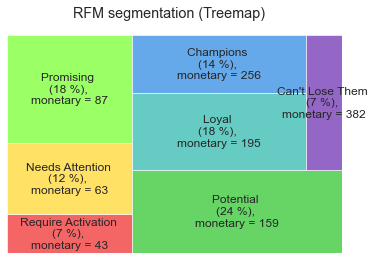

In [18]:
def plot_treemap(df_segments: pd.DataFrame, cluster_col=CLUSTER_COL, pct_col=CLUSTER_PCT, colormap=None):

    cluster_id_numeric = (
        cluster_col in df_segments.select_dtypes('number').columns)
    cluster_id_categoric = (
        cluster_col in df_segments.select_dtypes('category').columns)
    if cluster_id_numeric or cluster_id_categoric:
        print('converting segment labels to string')
        df_segments[cluster_col] = [
            f'seg. {i}' for i in df_segments[cluster_col]]
    df_segment_labels = list(df_segments[cluster_col])
    if colormap is None:
        n = len(df_segments)
        df_segment_colors = sns.color_palette(
            'nipy_spectral_r', n_colors=n).as_hex()
        # treemap requires an inverted colormap, standard colormaps no good
        colormap = dict(zip(df_segment_colors, df_segment_labels))

    df_summary = df_segments[[cluster_col, pct_col, 'MonetaryValue']]

    def row_label(row):
        return (f"{row[cluster_col]} \n({row[pct_col]:.0f} %), "
                + f"\nmonetary = {row['MonetaryValue']:.0f}")
    df_treemap = df_summary.sort_values(by='MonetaryValue')
    df_treemap['text'] = df_treemap.apply(lambda row: row_label(row), axis=1)
    # rfm_summary.loc[:,'text']= rfm_summary_text.values
    squarify.plot(sizes=df_treemap[pct_col],
                  label=df_treemap['text'], alpha=.6,
                  color=colormap)
    plt.axis('off')


plot_treemap(df_rfm_segments.droplevel(1, axis=1).reset_index())
plt.suptitle('RFM segmentation (Treemap)')
to_png()


"RFM_Segmentation_Classique_(3D_plot).png"


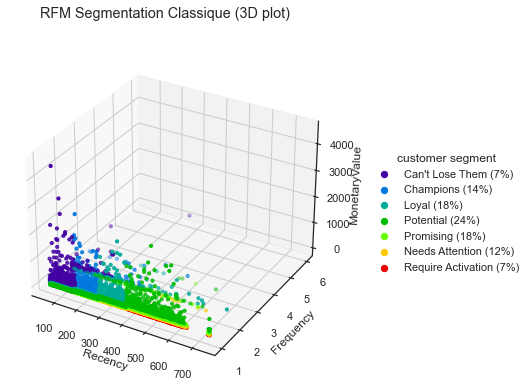

In [19]:
def plot_3d(df: pd.DataFrame, label_col=CLUSTER_COL, segments=None, colors=None):
    """Plot en 3 dimensions après avoir attribué les clusters"""
    if segments is None:
        segments = calc_cluster_order(df)
    if colors is None:
        colors = sns.color_palette(
            'nipy_spectral', n_colors=len(segments)).as_hex()
    xcol = df.columns[0]
    ycol = df.columns[1]
    zcol = df.columns[2]
    # This import registers the 3D projection, but is otherwise unused.
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection='3d')
    i = 0
    if not (label_col in df.columns):
        # index = label_col
        df = df.copy().reset_index()
    n = len(df)
    for segment in segments:
        data = df[df[label_col] == segment]
        pourcentage = round(len(data)/n*100)
        # print(f'{segment} : {data.shape}')
        ax.scatter(data=data,
                   xs=xcol, ys=ycol, zs=zcol,
                   label=f'{segment} ({pourcentage}%)',
                   s=10,
                   c=colors[i])
        i += 1
    # Titre des axes et titre graphique
    ax.set_xlabel(xcol)
    ax.set_ylabel(ycol)
    ax.set_zlabel(zcol)
    plt.legend(title='customer segment', bbox_to_anchor=(
        1.6, 0.5), loc=5, markerscale=2)


plot_3d(df_rfm)
plt.suptitle('RFM Segmentation Classique (3D plot)')
to_png()


La segmentation RFM ne discrimine pas par fréquence


"Segmentation_par_RFM_-_monetary_vs_recency.png"


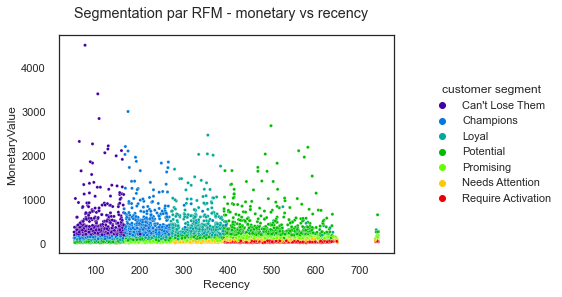

In [20]:
cluster_order = calc_cluster_order(df_rfm)
sns.scatterplot(data=df_rfm, x='Recency', y='MonetaryValue',
                hue=CLUSTER_COL, hue_order=cluster_order, palette='nipy_spectral', s=10)
plt.legend(title='customer segment', bbox_to_anchor=(1.5, 0.5), loc=5)
plt.suptitle('Segmentation par RFM - monetary vs recency')
to_png()


### Conclusions sur essai 1

La segmentation RFM n'est pas très discriminant:

- 97% des clients ont fait une seule commande, donc la fréquence n'influence pas trop le score
- les clients plus récents ont un score plus favorable que les anciens clients, sans justificatif.
- les clients qui ont fait des commandes de bas valeur ne sont pas mis en valeur

---


# Essai 2 - Kmeans clustering avec les variables RFM

Pour comparaison, on peut répéter la segmentation RFM via clustering.

Pour la meilleure performance, il faut que :

- les distributions sont au même échelle,
- idéalement avec des distributions normales pour réduire l'impact des outliers

Cette section investigue l'influence de preprocessing sur les clusters.


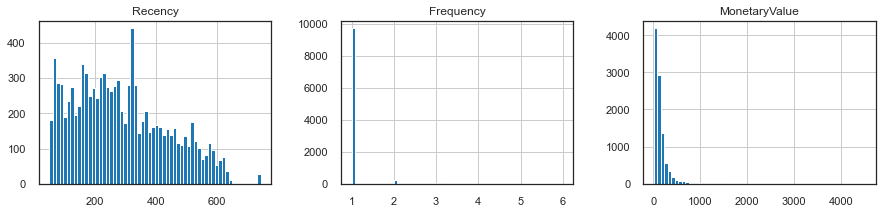

In [21]:
df_clients[FEATURES_RFM].hist(figsize=(15, 3), bins=60, layout=[1, 3])
plt.subplots_adjust()


### Clustering RFM avec MinMaxScaler

Le MinMaxScaler met les distributions au même échelle, mais ça ne résout pas le problème des outliers


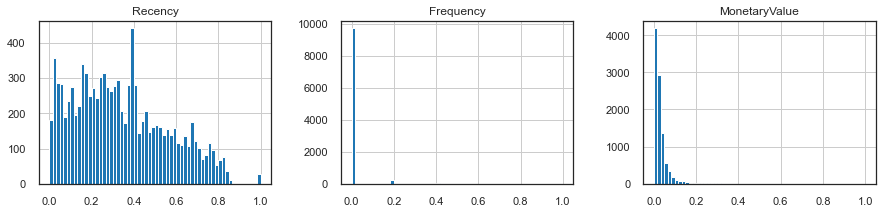

In [22]:
from sklearn.preprocessing import MinMaxScaler

pd.DataFrame(MinMaxScaler().fit_transform(
    df_clients[FEATURES_RFM]), columns=FEATURES_RFM).hist(figsize=(15, 3), bins=60, layout=[1, 3])
plt.subplots_adjust()


"RFM_Segmentation_Kmeans_avec_MinMaxScaler_(3D_plot).png"


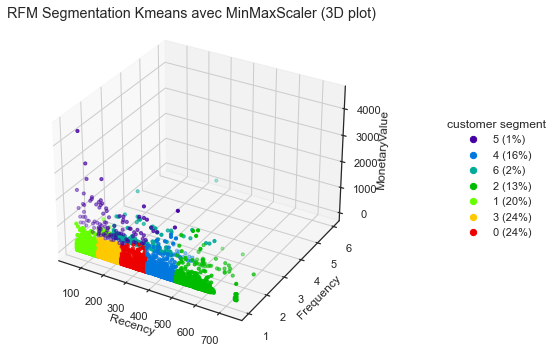

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


def run_fit_cluster_labels(df: pd.DataFrame, features, model):
    model.fit(df[features])
    clf: KMeans = model.named_steps['clf']
    df_labels = pd.DataFrame({CLUSTER_COL: clf.labels_},
                             index=df.index).astype('category')
    # cluster_centers=clf.cluster_centers_
    df_clusters = df[features].join(df_labels)
    return df_clusters


model_min_max_kmeans = Pipeline(steps=[
    ('preprocessor', MinMaxScaler()),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
])

clusters = df_clients.pipe(
    run_fit_cluster_labels, FEATURES_RFM, model_min_max_kmeans)
clusters.pipe(plot_3d)

plt.suptitle('RFM Segmentation Kmeans avec MinMaxScaler (3D plot)', y=0.9)
to_png()


Le MinMaxScaler (et StandardScaler) :

- discriminer la plupart des clients qui ont fait plusieurs commandes (cluster id = 6)
- n'arrive pas à discriminer les valeurs monétaires, car les outliers réduit la sensibilité à cette variable.


### Clustering RFM avec Logarithme et StandardScaler


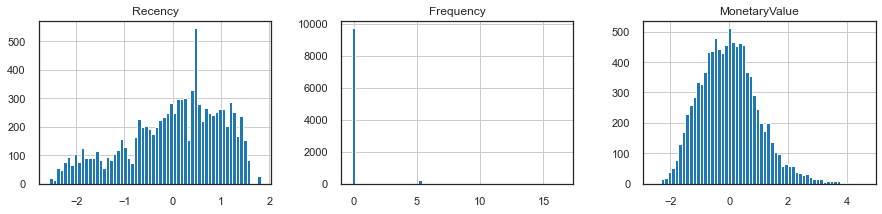

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer

log_scale_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('log', FunctionTransformer(func=np.log1p,
                                inverse_func=np.expm1, validate=False)),
    ('scale', StandardScaler()),
])
pd.DataFrame(log_scale_transformer.fit_transform(
    df_clients[FEATURES_RFM]), columns=FEATURES_RFM).hist(figsize=(15, 3), bins=60, layout=[1, 3])
plt.subplots_adjust()


"Segmentation_RFM_par_Kmeans_(k=7),_log_scale_transformer_(3D_plot).png"


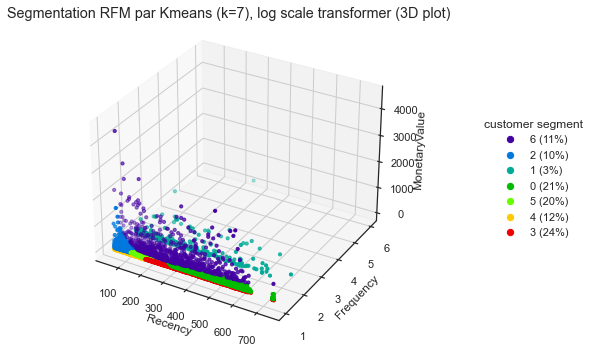

In [25]:
model_logscale_kmeans = Pipeline(steps=[
    ('preprocessor', log_scale_transformer),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
])

clusters = df_clients.pipe(
    run_fit_cluster_labels, FEATURES_RFM, model_logscale_kmeans)
clusters.pipe(plot_3d)

plt.suptitle(
    'Segmentation RFM par Kmeans (k=7), log scale transformer (3D plot)', y=0.9)
to_png()


"Segmentation_RFM_par_Kmeans_(k=7),_log_scale_transformer.png"


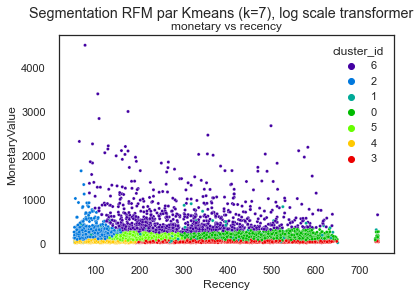

In [26]:
cluster_order = calc_cluster_order(clusters)
sns.scatterplot(data=clusters, x='Recency',
                y='MonetaryValue', hue=CLUSTER_COL, hue_order=cluster_order, s=10, palette='nipy_spectral')
plt.suptitle('Segmentation RFM par Kmeans (k=7), log scale transformer')
plt.title('monetary vs recency')
to_png()


La transformation log suivi par la mise à la même échelle :

- élimine l'influence d'outliers des valeurs monétaires
- nuance les clients par les trois variables (Récence, Fréquence et Montant moyenne dépensé)
- requiert que toutes les variables ont des distributions asymétriques, avec un skew positive


### Clustering RFM avec QuantileTransformer

L'inconvénient de la transformation log, c'est qu'il exige des valeurs numériques positives et est plus adapté aux distibutions avec un grand skew positive

On essaie un quantile transformer pour transformer les distributions vers une distribution normale

- Cette transformation est non-linéaire et risque de créer une distortion des corrélations entre les variables, mais permet d'utiliser les mesures de distance entre points plus comparables


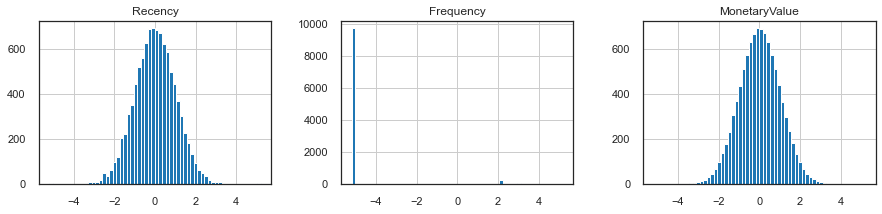

In [27]:
from sklearn.preprocessing import QuantileTransformer

quantile_transformer = QuantileTransformer(
    output_distribution='normal', random_state=RANDOM_SEED)

pd.DataFrame(quantile_transformer.fit_transform(
    df_clients[FEATURES_RFM]), columns=FEATURES_RFM).hist(figsize=(15, 3), bins=60, layout=[1, 3])
plt.subplots_adjust()


"RFM_Segmentation_Kmeans_avec_QuantileTransformer_(3D_plot).png"


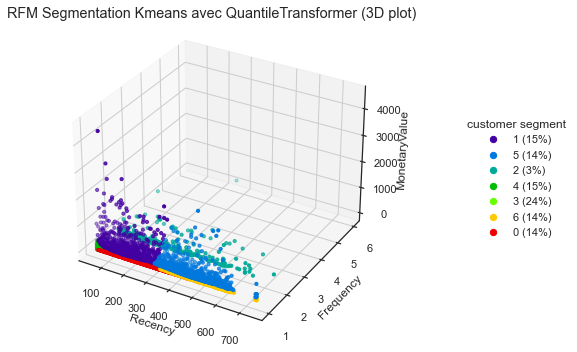

In [28]:
model_quantile_kmeans = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(
        output_distribution='normal', random_state=RANDOM_SEED)),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
])

clusters = df_clients.pipe(
    run_fit_cluster_labels, FEATURES_RFM, model_quantile_kmeans)
clusters.pipe(plot_3d)
plt.suptitle(
    'RFM Segmentation Kmeans avec QuantileTransformer (3D plot)', y=0.9)
to_png()


"Segmentation_RFM_par_Kmeans_(k=7),_quantile_transformer.png"


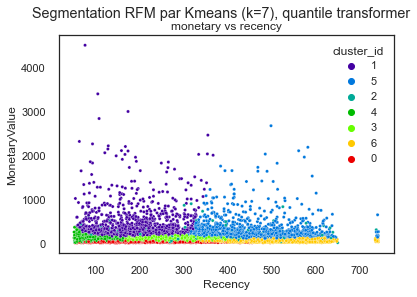

In [29]:
cluster_order = calc_cluster_order(clusters)
sns.scatterplot(data=clusters, x='Recency',
                y='MonetaryValue', hue=CLUSTER_COL, hue_order=cluster_order, s=10, palette='nipy_spectral')
plt.suptitle('Segmentation RFM par Kmeans (k=7), quantile transformer')
plt.title('monetary vs recency')
to_png()


### Aggregation des clusters


In [30]:
def agg_top(x): return x if len(x)==1 else x.value_counts().index[0]
def group_clusters(df: pd.DataFrame, cluster_col=CLUSTER_COL):
    """Aggregate clusters on numeric and categorical columns"""
    df = df.copy()
    df[cluster_col] = df[cluster_col].astype('category')

    # effectif et fréquence des clusters
    df_cluster_sizes = df.groupby(cluster_col).agg(
        cluster_size=(cluster_col, 'count'))
    n = len(df)
    df_cluster_sizes['cluster_pct'] = np.round(
        df_cluster_sizes['cluster_size']/n * 100, 2)
    # df_cluster_size=(df[cluster_col].value_counts(normalize=False)*100).to_frame(name='cluster_size')
    # df_cluster_pct=(df[cluster_col].value_counts(normalize=True)*100).to_frame(name='cluster_pct')

    # moyennes des colonnes numériques
    num_cols = df.select_dtypes('number').columns
    df_cluster_means = df.groupby(cluster_col)[num_cols].mean()
    df_agg = df_cluster_sizes.join(df_cluster_means)

    #
    obj_cols = df.select_dtypes('object').columns
    if len(obj_cols) > 0:
        df_cluster_max = df.groupby(cluster_col)[obj_cols].agg(agg_top)
        df_agg = df_agg.join(df_cluster_max)

    if VALUE_COL in df_agg.columns:
        df_agg = df_agg.sort_values(by=VALUE_COL, ascending=False)
    return df_agg.reset_index()


group_clusters(clusters)


cluster_id  cluster_size  cluster_pct  Recency  Frequency  MonetaryValue
0          1          1503        15.03   189.30       1.00         392.27
1          5          1419        14.19   452.40       1.00         286.17
2          2           293         2.93   277.53       2.10         151.57
3          4          1520        15.20    97.15       1.00         108.51
4          3          2431        24.31   276.76       1.00         106.06
5          6          1429        14.29   495.97       1.00          64.35
6          0          1405        14.05   223.33       1.00          40.20

converting segment labels to string
"Segments_identifiés_par_segmentation_KMeans_(k=7)_sur_features_RFM.png"


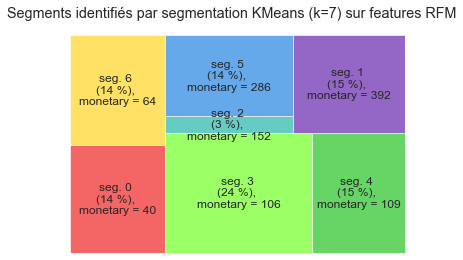

In [31]:
rfm_kmeans = clusters.pipe(group_clusters)
plot_treemap(rfm_kmeans)
plt.suptitle(
    'Segments identifiés par segmentation KMeans (k=7) sur features RFM')
to_png()


La transformation avec quantile_transformer produit des segments distribué sur les features


### Visualise les valeurs

#### plotting variables to help explain data

- <https://stackoverflow.com/questions/57340166/how-to-plot-the-pricipal-vectors-of-each-variable-after-performing-pca>
- <https://towardsdatascience.com/principal-components-analysis-plot-for-python-311013a33cd9>


pca feature labels : ['Recency', 'Frequency', 'MonetaryValue']
"KMeans_Clusters_sur_features_RFM.png"


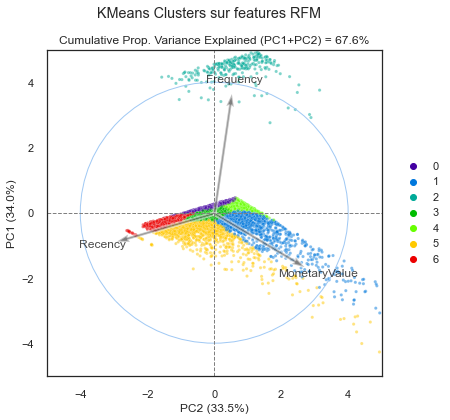

In [32]:
from sklearn.decomposition import PCA
import math

AXIS_RANKS_0_1 = [(0, 1)]
AXIS_RANKS_0_3 = [(0, 1),(2, 3)]
AXIS_RANKS_0_5 = [(0, 1),(2, 3),(4, 5)]


def plot_principal_components(pca_df, pca, feature_labels=None, cluster_labels_=None, cluster_order_=None,
                              palette_=CLUSTER_PALETTE, alpha=0.5, limit=5, axis_ranks=AXIS_RANKS_0_1):
    """
    Plot les données (pca_df) et les vecteurs/circles de corrélations (pca) sur les factorial planes

    Parameters
    ---------
    pca_df : les données transformés dans les composants principales (shape=n_components * n_registres)
    pca : le model pca qui fourni les components (shape=n_components * n_features)
    feature_labels: une list/array/pd.Series dans la même ordre que les colonnes utilisés pendant pca.fit(df).
            Si absent, les vecteurs auront les noms 'var 1', 'var 2', etc...
    cluster_labels: une list/array/pd.Series dans la même ordre que les registres df et pca_df
    cluster_order: ordre d'affichage des clusters (permet par exemple d'ordonner par valeur monetaire)
    palette: couleurs pour distinguer les clusters
    """
    n_ranks = len(axis_ranks)
    n_cols = min(n_ranks, 3)
    n_rows = int(math.ceil(n_ranks/n_cols))

    fig: Figure = plt.figure(1, figsize=(n_cols*6, n_rows*6))
    n_ax = 1
    for d1, d2 in axis_ranks:
        # axis_ranks=[(0,1),(2,3),(4,5)] = affiche les 3 premiers plans factoriels (les 6 premières composantes)
        if d2 < pca_df.shape[1]:
            ax = fig.add_subplot(n_rows, n_cols, n_ax)
            n_ax = n_ax+1
            # plot des points
            sns.scatterplot(x=pca_df[:, d1], y=pca_df[:, d2],
                            hue=cluster_labels_,
                            hue_order=cluster_order_,
                            palette=palette_,
                            s=10, alpha=alpha, ax=ax)

            # définition des limites du graphique
            (xmin, xmax) = ax.get_xlim()
            (ymin, ymax) = ax.get_ylim()
            xlim = min(limit, max(abs(xmin), abs(xmax)))
            ylim = min(limit, max(xlim, abs(ymin), abs(ymax)))
            xlim = max(xlim, ylim)
            ax.set_xlim(-xlim, xlim)
            ax.set_ylim(-ylim, ylim)

            # affichage des lignes horizontales et verticales
            plt.plot([-xlim, xlim], [0, 0], color='grey', lw=1, ls='--')
            plt.plot([0, 0], [-ylim, ylim], color='grey', lw=1, ls='--')

            # affichage du cercle
            scale = 0.8  # pourcent de largeur pour le cercle
            arrow_scale = max(xlim, ylim)*scale  # limit/1.2
            quiver_scale = 2/scale
            text_scale = arrow_scale*1.15
            circle = plt.Circle((0, 0), arrow_scale,
                                facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            coeff = pca.components_.T
            n = len(coeff)
            for i in range(n):
                x_ = coeff[i, d1]
                y_ = coeff[i, d2]
                plt.quiver(0, 0, x_, y_, scale=quiver_scale,
                           ls='-', color='black', lw=2, alpha=0.5)
                # plt.arrow(0, 0, x_*arrow_scale, y_* arrow_scale,
                # ls='-', color='black', lw=2, alpha=0.5)
                if feature_labels is None:
                    label = "Var"+str(i+1)
                else:
                    label = feature_labels[i]
                plt.text(x_ * text_scale, y_ * text_scale,
                         label, color='black', ha='center', va='center', alpha=0.7)

            # nom des axes, avec le pourcentage d'inertie expliqué
            explained = pca.explained_variance_ratio_ * 100
            cumvar = explained[d1]+explained[d2]
            pc1 = f'PC{(d1+1):.0f}'
            pc2 = f'PC{(d2+1):.0f}'
            plt.ylabel(f'{pc1} ({explained[d1]:.1f}%)')
            plt.xlabel(f'{pc2} ({explained[d2]:.1f}%)')
            plt.title(
                f'Cumulative Prop. Variance Explained ({pc1}+{pc2}) = {cumvar:.1f}%')
            if not cluster_labels_ is None:
                plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5)


def plot_clusters_on_pca(df: pd.DataFrame, preprocessor=StandardScaler(),
    cluster_col=CLUSTER_COL, cluster_order=None, palette=CLUSTER_PALETTE, 
    alpha=0.5, limit=5, axis_ranks=AXIS_RANKS_0_1):
    """
    Visualise les résultats de clustering. Les labels sont fournis :
    - soit dans une colonne de la data ; ou
    - dans une série, séparément de la data
    """
    cluster_labels = None
    df = df.copy()
    if cluster_col in df.columns:
        df[cluster_col] = df[cluster_col].astype('category')
        cluster_labels = df[cluster_col]
        
    df = df.select_dtypes('number')
    feature_labels = list(df.columns)
    print(f'pca feature labels : {feature_labels}')
    
    # si le dataframe de clusters est fourni sans preprocessing, il faut au moins appliquer StandardScalar
    # pour d'autres visualisations, passer preprocess le clusters
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', PCA(n_components=len(df.columns)))
    ])

    pca_df = model.fit_transform(df)
    pca = model.named_steps['pca']

    if palette is None:
        if not cluster_labels is None:
            segments = list(pd.Series(cluster_labels).unique())
            print(f'nb_clusters : {len(segments)}')
            palette = sns.color_palette(
                'nipy_spectral', n_colors=len(segments))

    if cluster_order is None:
        cluster_order = calc_cluster_order(df, cluster_col)

    plot_principal_components(pca_df, pca, feature_labels=feature_labels,
                              cluster_labels_=cluster_labels, cluster_order_=cluster_order,
                              palette_=palette, alpha=alpha, limit=limit, axis_ranks=axis_ranks)
    return None


plot_clusters_on_pca(clusters)
plt.suptitle('KMeans Clusters sur features RFM')
to_png()


converting segment labels to string


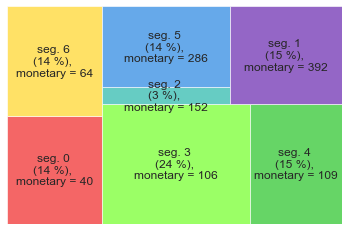

In [33]:

plot_treemap(group_clusters(clusters))


### Conclusion sur essai 2

La segmentation RFM par clustering KMeans (k= 7 segments) produit des résultats similaires à la segmentation RFM classique :

- il faut mettre les variables à la même échelle
- il faut éliminer les outliers par transformation des variables (ou les traites à part)
- Il y a 6 clusters sur récence et valeur monétaire.
- Il y un nouveau cluster (label = 2) qui represent le 3% de clients qui ont fait plus d'une commande

On n'a toujours beaucoup d'information pour aider à cibler nos clients.

---


# Essai 3 - Clustering KMeans sur d'autres indicateurs

L'analyse des données a fourni d'autres indicateurs de nos clients


In [34]:
print(list(df_clients.columns))


['customer_unique_id', 'dernier_achat', 'Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'payment_mode', 'favourite_category', 'time_of_day', 'weekday', 'products_per_order']


Text(0.5, 0.98, 'Distributions des indicateurs client')

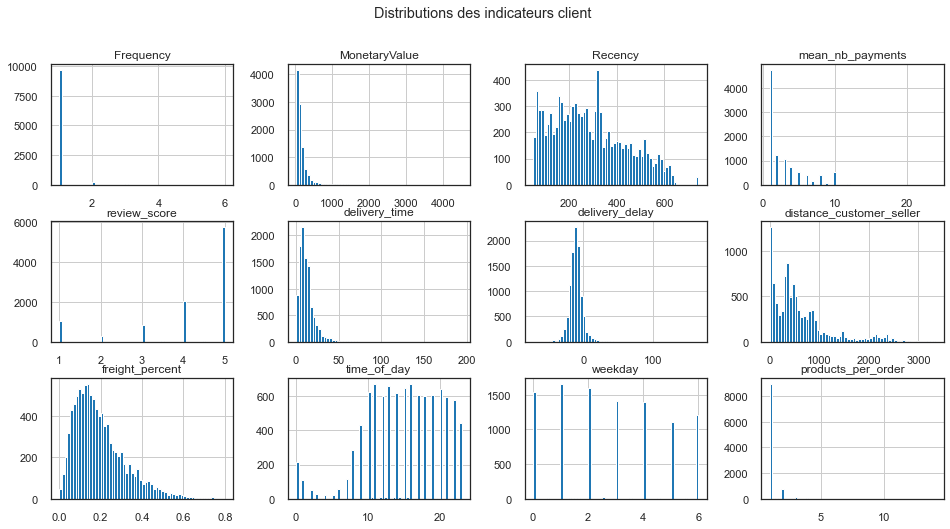

In [35]:
df_clients.hist(figsize=(16, 8), bins=60, layout=[3, 4])
plt.suptitle('Distributions des indicateurs client')


Pour clustering KMeans, il faut

1. réduire l'influence des outliers
1. mettre les variables à la même échelle
1. choisir les features qui explique le plus de variance


### Réduction de l'influence des outliers

#### Detection d'anomalies avec Isolation Forest

On suppose que 0.5% des clients ne sont pas representative de chaque segment de clients :

Par exemple :

- des très haut valeurs monétaires
- des très fréquents acheteurs
- des livraisons extrêmement en retard
- des paiements en 24 fois
- des frappes erronées

Ces données peuvent avoir une influence trop fort sur les clusters.
On va les identifier, et si besoin, les éliminer.

- <https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html>
- <https://practicaldatascience.co.uk/machine-learning/how-to-use-the-isolation-forest-model-for-outlier-detection>
- <https://machinelearningmastery.com/anomaly-detection-with-isolation-forest-and-kernel-density-estimation/>

Text(0.5, 0.98, 'Anomalies détectés par IsolationForest (0.5%)')

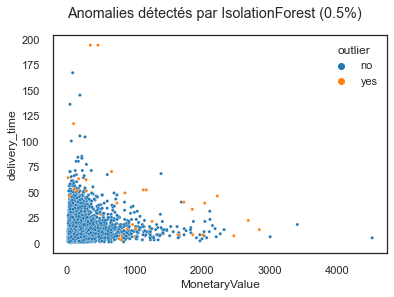

In [36]:
from sklearn.ensemble import IsolationForest


def find_outliers(df: pd.DataFrame, num_cols=None, alpha=0.005, random_state=RANDOM_SEED):
    """Methode non-optimisé pour éliminer des points isolés pour réduire l'influence sur le clustering"""
    df = df.copy()
    if num_cols is None:
        num_cols = df.select_dtypes('number').columns
    model = IsolationForest(contamination=alpha, random_state=random_state)
    model.fit(df[num_cols].values)
    # outliers=model.predict(df[num_cols]<0)
    # enregistre comme une colonne non numérique
    df['outlier'] = np.where(model.predict(
        df[num_cols].values) < 0, 'yes', 'no')
    return df


df_clients = find_outliers(df_clients)

sns.scatterplot(data=df_clients, x='MonetaryValue',
                y='delivery_time', hue='outlier', palette='tab10', s=10)

plt.suptitle('Anomalies détectés par IsolationForest (0.5%)')


On regarde les outliers sur les 2 premiers composants principaux


pca feature labels : ['Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'time_of_day', 'weekday', 'products_per_order']
"Visualisation_d'outliers_sur_les_composants_principales.png"


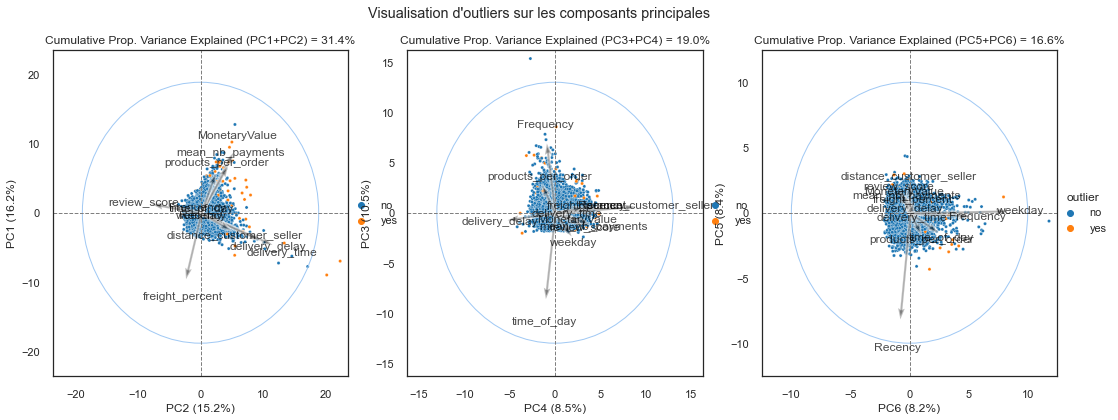

In [37]:

plot_clusters_on_pca(df_clients, cluster_col='outlier',
                     palette='tab10', limit=50, alpha=1, axis_ranks=AXIS_RANKS_0_5)
plt.legend(title='outlier', bbox_to_anchor=(1.2, 0.5), loc=5)
plt.suptitle("Visualisation d'outliers sur les composants principales")
to_png()


In [38]:
def drop_outliers(df):
    if 'outlier' in df.columns:
        # return df[~(df['outlier'] == 'yes')]
        return df[~(df['outlier'] == 'yes')].drop('outlier', axis=1)
    return df


pca feature labels : ['Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'time_of_day', 'weekday', 'products_per_order']


Text(0.5, 0.98, 'Composants principaux après élimination des points isolés (0.5%)')

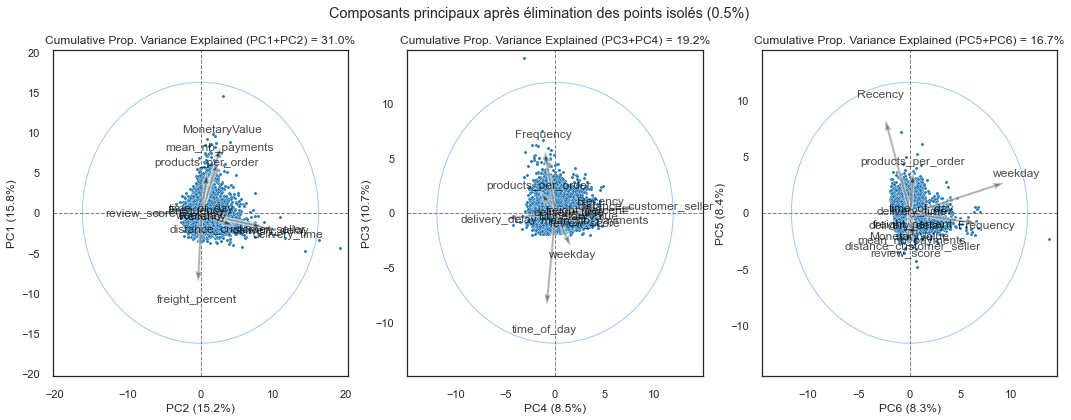

In [39]:
(plot_clusters_on_pca(
    df_clients.pipe(drop_outliers).select_dtypes('number'),
     limit=50, alpha=1, axis_ranks=AXIS_RANKS_0_5))
plt.suptitle('Composants principaux après élimination des points isolés (0.5%)' )

In [40]:
clients = df_clients.pipe(drop_outliers)


### Transformation pour éliminer l'asymétrie (skew)

Les distributions asymétriques et outliers ont l'effet de réduire l'influence d'un variable, car ils font que la mise à l'échelle font que la plupart des données sont trop proches

On va essayer plusieurs transforms pour éliminer les outliers


In [41]:
def transform_skew(df: pd.DataFrame, cols=None, boxcox=True):
    if cols is None:
        cols = df.select_dtypes('number').columns
    x_transforms = df[cols].skew().to_frame(name='feature.skew()')
    x_transforms['square'] = np.power(df[cols], 2).skew()
    positive_cols = []
    for col in cols:
        if df[col].min() >= 0:
            positive_cols.append(col)
    x_transforms['sqrt'] = np.sqrt(df[positive_cols]).skew()
    x_transforms['log'] = np.log1p(df[positive_cols]).skew()
    x_transforms['quantile'] = pd.DataFrame(
        quantile_transformer.fit_transform(df[cols]), columns=cols).skew()
    if boxcox:
        boxcox_df = pd.DataFrame()
        for col in positive_cols:
            boxcox_df[col], lambda_ = scipy.stats.boxcox(df[col]+0.01)
        x_transforms['box-cox'] = boxcox_df.skew()
    return x_transforms

print('skew pour les variables après divers transformations')
abs(transform_skew(df_clients)
    ).style.background_gradient(axis=1).highlight_min(axis=1)

skew pour les variables après divers transformations


In [42]:

print('skew pour les variables après divers transformations')
abs(transform_skew(
    df_clients.pipe(drop_outliers))
    ).style.background_gradient(axis=1).highlight_min(axis=1)


skew pour les variables après divers transformations


La transformation quantile est la plus efficace pour réduire l'influence des outliers.


#### Quantile preprocessor

La transformation quantile est efficace pour :

- réduit le skew (élimination des outliers)
- mettre les variables à la même échelle

Il permet de comparer les distances entre les points sur plusieurs dimensions.

Néanmoins, c'est plus difficile d'interpreter, car c'est une transformation très non-linéaire.


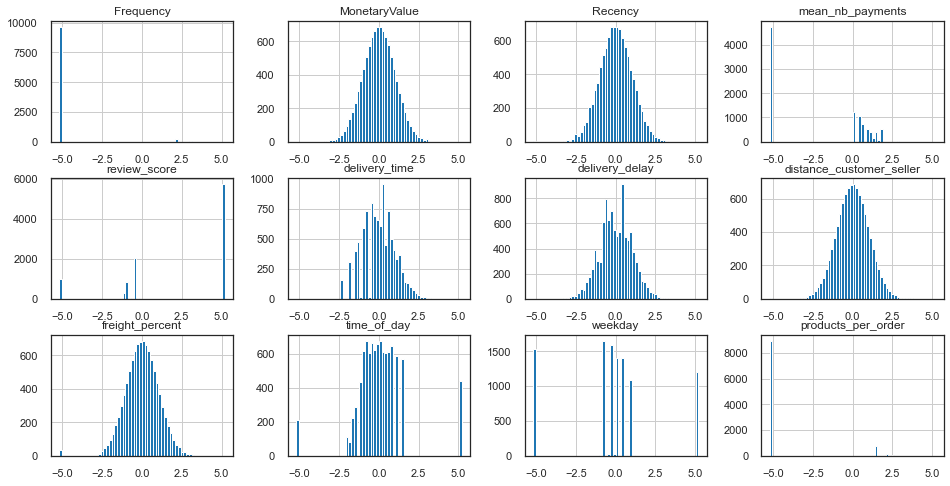

In [43]:
numeric_cols = df_clients.select_dtypes('number').columns

quantile_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('quantile', QuantileTransformer(output_distribution='normal',random_state=RANDOM_SEED)),
])

clients_quantiled = pd.DataFrame(
    data=quantile_transformer.fit_transform(clients[numeric_cols]),
    columns=numeric_cols
)

clients_quantiled.hist(figsize=(16, 8), bins=60, layout=[3, 4])
plt.subplots_adjust()


#### Custom preprocessor

Un alternative sera de transformer chaque variable individuellement:

- standard scaler : feature.skew < 0.5 et les variables negative
  - (delivery_delay, review_score, recency)
- sqrt + scaler : (sqrt(feature)).skew < 0.5
  - (distance_customer_seller, freight_percent)
- log + scaler : toutes les autres variables

C'est plus compliqué à mettre en œuvre :


In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


def make_custom_preprocessor(data):
    """Créer un preprocessor basé sur propriétés des colonnes
    mélange de log, scale, square_root et catégorique
    """
    def split_features(df):
        """Diviser le processing des features basé sur leur dtype, skew"""
        num_cols = df.select_dtypes('number').columns.tolist()

        # (abs(feature.skew)) < 0.5) ou (feature < 0).any()
        feat_skew = df[num_cols].skew()
        scale_cols = feat_skew[feat_skew < 0.5].index.tolist()

        negative_cols = df[num_cols].columns[(df[num_cols] < 0).any()]
        scale_cols = [*scale_cols, *negative_cols]

        positive_cols = df[num_cols].columns[~(df[num_cols] < 0).any()]

        sqrt_skew = np.sqrt(df[positive_cols]).skew()
        sqrt_cols = list(
            set(sqrt_skew[sqrt_skew < 0.5].index.tolist()) - set(scale_cols))

        log_cols = list(set(positive_cols)-(set(scale_cols+sqrt_cols)))

        categ_cols = df.select_dtypes(exclude='number').columns.tolist()
        category_cols = []
        for col in categ_cols:
            if df[col].nunique() < 22:
                category_cols.append(col)
        return scale_cols, log_cols, sqrt_cols, category_cols

    scale_features, log_features, sqrt_features, category_features = split_features(
        data)

    # (abs(feature.skew)) < 0.5) ou (feature < 0).any()
    scale_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('scale', StandardScaler())
    ])

    # (abs(sqrt(feature).skew) < 0.5)
    sqrt_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord', FunctionTransformer(func=np.sqrt,
         inverse_func=np.square, validate=False)),
        ('scale', StandardScaler())
    ])

    # les autres variables numériques
    log_scale_pipeline = Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
        ('log', FunctionTransformer(func=np.log1p,
         inverse_func=np.expm1, validate=False)),
        ('scale', StandardScaler()),
    ])

    category_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('simple_scale', scale_transformer, scale_features),
            ('log_scale', log_scale_pipeline, log_features),
            ('sqrt_scale', sqrt_transformer, sqrt_features),
            ('cat', category_transformer, category_features)
        ],
        remainder='drop'
    )

    return preprocessor


custom_preprocessor = make_custom_preprocessor(clients.select_dtypes('number'))

custom_pipeline = Pipeline(steps=[('preprocessor', custom_preprocessor)])
custom_pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('simple_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['Recency', 'review_score',
                                                   'time_of_day', 'weekday',
                                                   'delivery_delay']),
                                                 ('log_scale',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('log',
                                                                   FunctionTransformer(func=<ufun...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   FunctionTransformer(func=<ufunc 'sqrt'>,
                                                                                       inverse_func=<ufunc 'square'>)),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['distance_customer_seller',
                                                   'freight_percent']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  [])]))])

In [45]:
def get_features_out(df: pd.DataFrame, pipe):
    """
    Get column names after preprocessing

    assumes (requires preprocessors with following structure):
    - all named transformers, if present, are in same order as listed below
    - if preprocessor has other transformers, add to list below
    - only final transformer (named 'cat') adds columns, via an encoder step named 'ohe'
    - if imputer is used, it does not add indicator columns
    """

    def get_features_in_(trans: ColumnTransformer, name=None):
        try:
            features = list(trans.named_transformers_[name].feature_names_in_)
        except:
            # named transformer doesn't exist in pipeline, return empty list
            features = []
        return features

    pipe.fit(df)
    if hasattr(pipe, 'named_steps'):
        trans: ColumnTransformer = pipe.named_steps['preprocessor']
    else:
        trans = pipe
    # SimpleImputer, FunctionTransformer, StandardScalar do not implement get_feature_names_out

    # Get feature names of numeric columns
    num_features = get_features_in_(trans, 'num')
    scale_features = get_features_in_(trans, 'simple_scale')
    log_features = get_features_in_(trans, 'log_scale')
    sqrt_features = get_features_in_(trans, 'sqrt_scale')
    try:
        cat_encoder = trans.named_transformers_['cat']
        ohe = cat_encoder.named_steps['ohe']
        category_features = list(
            ohe.get_feature_names_out(cat_encoder.feature_names_in_))
    except:
        category_features = []
    features_out_ = (num_features+scale_features + log_features
                     + sqrt_features + category_features)
    return features_out_


# check
features_in = list(clients.select_dtypes('number').columns)
features_out = get_features_out(
    clients[features_in], pipe=make_custom_preprocessor(clients[features_in]))
print(f'features_in : {features_in}')
print(f'features_out : {features_out}')


features_in : ['Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'time_of_day', 'weekday', 'products_per_order']
features_out : ['Recency', 'review_score', 'time_of_day', 'weekday', 'delivery_delay', 'mean_nb_payments', 'Frequency', 'MonetaryValue', 'delivery_time', 'products_per_order', 'distance_customer_seller', 'freight_percent']


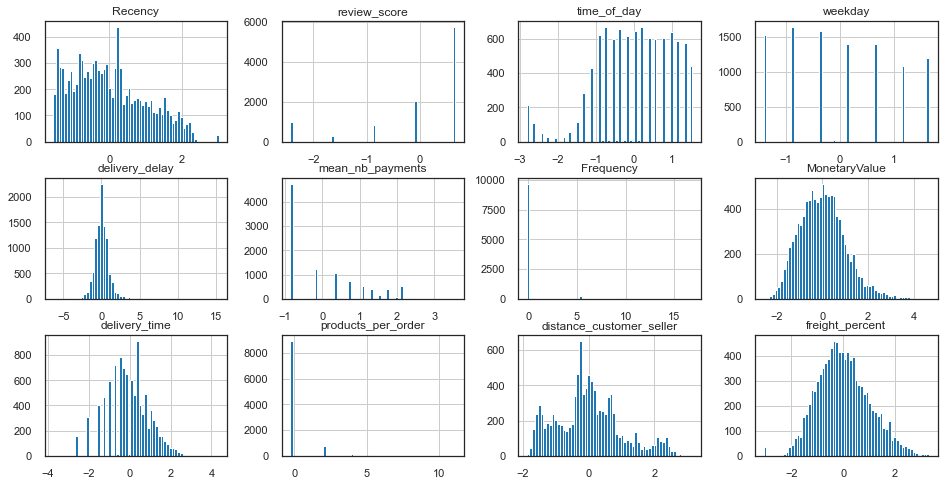

In [46]:
clients_custom_scaled = pd.DataFrame(
    data=custom_pipeline.fit_transform(clients[features_in]),
    columns=features_out
)

clients_custom_scaled.hist(figsize=(16, 8), bins=60, layout=[3, 4])
plt.subplots_adjust()


## Feature selection pour Kmeans

On peut utiliser PCA pour identifier les variables qui explique le plus de variance entre les points


[ 15.8  31.   41.7  50.2  58.6  66.9  75.   82.8  88.9  94.3  98.1 100. ]
[ 17.8  33.   44.2  52.7  61.1  69.3  77.4  85.1  91.3  96.7  98.8 100. ]
[ 17.2  32.   43.3  52.1  60.5  68.7  76.8  84.3  91.   96.8  98.7 100. ]
"pca_var_explained_scree_plot.png"


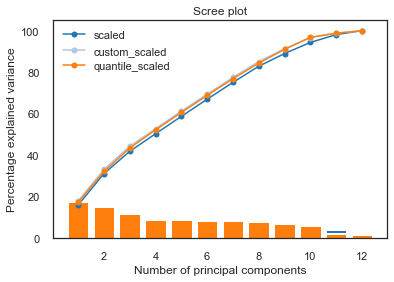

In [47]:
from matplotlib.ticker import MaxNLocator


def display_scree_plot(pca_: PCA, label: str = None):
    """
    Display a scree plot with cumulative explained variance.
    Parameters
    ----------
    pca_    fitted PCA decomposition
    label   label for legend of the plot if comparing scree plots

    Returns
    -------
    None
    """
    ### """Display a scree plot for the pca"""
    scree_ = pca_.explained_variance_ratio_ * 100
    print(np.round(np.cumsum(scree_), 1))
    plt.bar(np.arange(len(scree_)) + 1, scree_,)
    plt.plot(np.arange(len(scree_)) + 1,
             scree_.cumsum(), marker='o', label=label)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.title('Scree Plot of PCA: Component Eigenvalues')

    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")


def run_pca(df):
    model = Pipeline(steps=[
        ('preprocessor', StandardScaler()),
        ('pca', PCA(n_components=len(df.columns)))
    ])

    pca_df = model.fit_transform(df)
    pca = model.named_steps['pca']
    return pca, pca_df


pca_scale, _ = run_pca(clients.select_dtypes('number'))

display_scree_plot(pca_scale, label='scaled')
pca_custom, _ = run_pca(clients_custom_scaled)
display_scree_plot(pca_custom, label='custom_scaled')
pca_quantile, _ = run_pca(clients_quantiled)
display_scree_plot(pca_quantile, label='quantile_scaled')
plt.legend()
to_png(f'pca_var_explained_scree_plot')


Les transformations custom n'améliore pas significativement la variance expliquée par les composants principaux.

Pour simplicité, on utilisera Quantile Transformer pour transformer les variables, sachant que les clusters seront différents avec une autre preprocessor

#### Vérification de manque de corrélation (linéaire) entre les variables apres transformation


"Pearson_correlations_entre_les_variables_numériques.png"


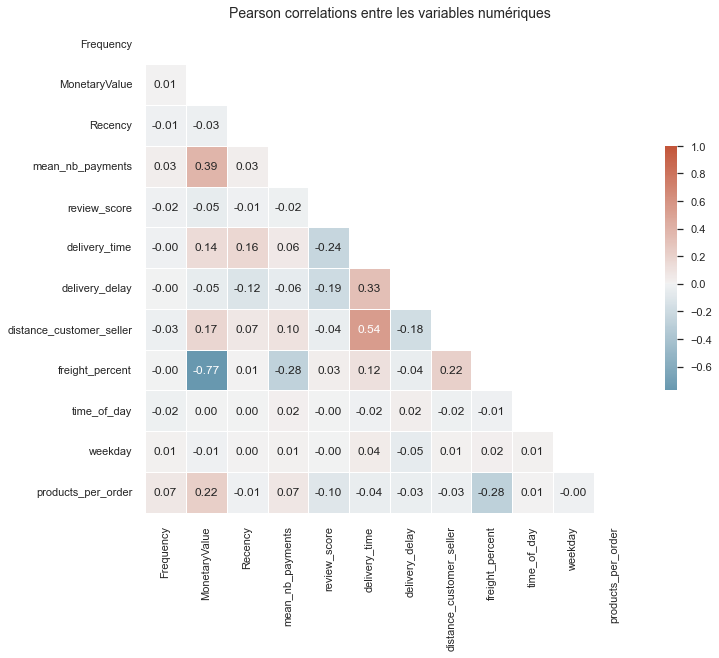

In [48]:
def plot_correlation_heatmap(df: pd.DataFrame, method_corr='pearson'):
    """
    Heatmap des correlations entre variables numériques
    Parameters
    ----------
    df
    method_corr

    Returns
    -------
    """

    corr_tab = df.select_dtypes('number').corr(method=method_corr)
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr_tab, dtype=bool))

    # Set up the matplotlib figure
    plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_tab, annot=True, fmt='.2f', mask=mask, cmap=cmap, vmax=1, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})


clients_quantiled.pipe(plot_correlation_heatmap, method_corr='spearman')
plt.title(f'Pearson correlations entre les variables numériques', size=14)
to_png()


pca feature labels : ['Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'time_of_day', 'weekday', 'products_per_order']
"PCA_après_Quantile_Transformation.png"


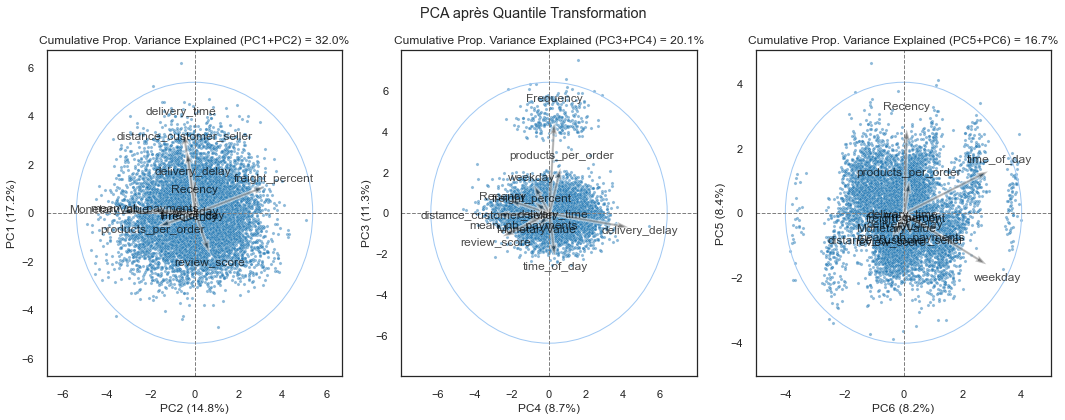

In [49]:
plot_clusters_on_pca(clients_quantiled,
axis_ranks=[(0, 1), (2, 3), (4, 5)],  limit=50)
plt.suptitle('PCA après Quantile Transformation')
to_png()


### Réduction des dimensions


Le premier 6 composantes principales explique 70% de la variance

- on regard les loadings sur ces 6 composants


#### Loadings des composants principaux

Les loadings indique la contribution de chaque variable a chaque composant principal :

- Positive loadings indicate a positively correlation
- Negative loadings indicate a negative correlation.

- <http://strata.uga.edu/8370/lecturenotes/principalComponents.html>
- <https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html>


In [50]:
def calc_loadings(df: pd.DataFrame, n_components=6):
    df = df.select_dtypes('number').copy()
    n_components = min(n_components, len(df.columns))
    model = Pipeline(steps=[
        ('preprocessor', StandardScaler()),
        ('pca', PCA(n_components=n_components))
    ])

    model.fit(df)
    pca = model.named_steps['pca']
    loadings = pd.DataFrame(
        pca.components_.T * np.sqrt(pca.explained_variance_),
        index=clients_quantiled.columns,
        columns=[f'PC{i}' for i in range(1, pca.components_.shape[0]+1)])

    # print(np.square(loadings).sum(axis=1))
    return loadings


loadings = calc_loadings(clients_quantiled)
# loadings.iloc[:, :6].sort_values(
loadings.sort_values(
    by='PC1').style.background_gradient(cmap='coolwarm', axis=None)


On voit que Frequency (PC4) et MonetaryValue (PC1) ont des correlations forts dans ces composants.
Recency semble moins intéressant (PC6)

Les loadings indique qu'il peut être intéressant d'ajouter au clustering :

- review_score (PC2 et PC3)
- mean_nb_payments (PC1, PC3, PC4)
- delivery_delay (PC2 et PC3)


## Essai 3 : Kmeans sur 5 indicateurs

En plus de RFM, on va essayer d'ajouter des variables qui séparent les clusters

- Review Score
- products_per_order


In [51]:
features_3 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments',
              'delivery_delay']
features_4 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments',
              'products_per_order']
features_5 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments',
              'products_per_order', 'Recency']
features_6 = ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments',
              'Recency']


pca feature labels : ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'products_per_order']
"PCA_(features_4)_après_Quantile_Transformation.png"


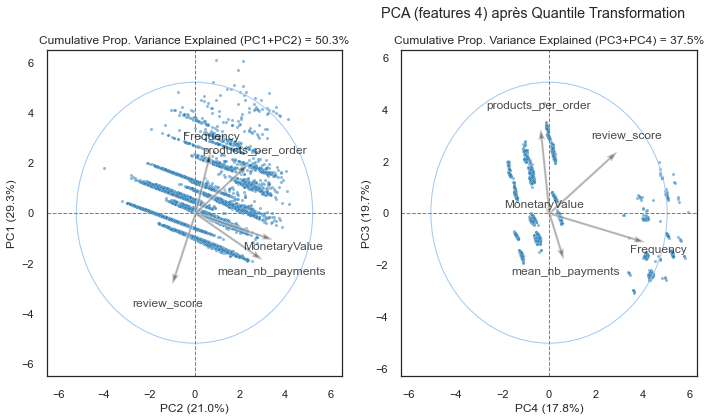

In [52]:
plot_clusters_on_pca(clients_quantiled[features_4], axis_ranks=[(
    0, 1), (2, 3), (4, 5)],  limit=50)
plt.suptitle('PCA (features 4) après Quantile Transformation')
to_png()


pca feature labels : ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'products_per_order', 'Recency']
"PCA_(features_5)_après_Quantile_Transformation.png"


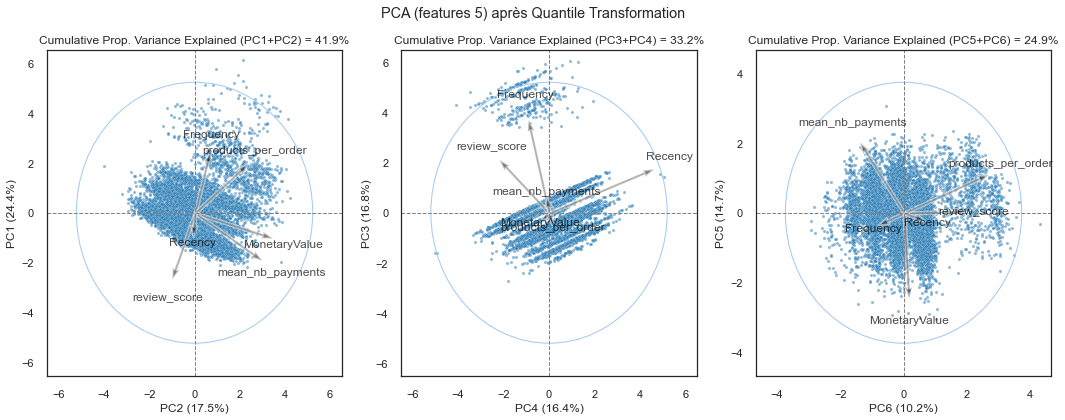

In [53]:
plot_clusters_on_pca(clients_quantiled[features_5], axis_ranks=[(
    0, 1), (2, 3), (4, 5)],  limit=50)
plt.suptitle('PCA (features 5) après Quantile Transformation')
to_png()


pca feature labels : ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'Recency']
"PCA_(features_6)_après_Quantile_Transformation.png"


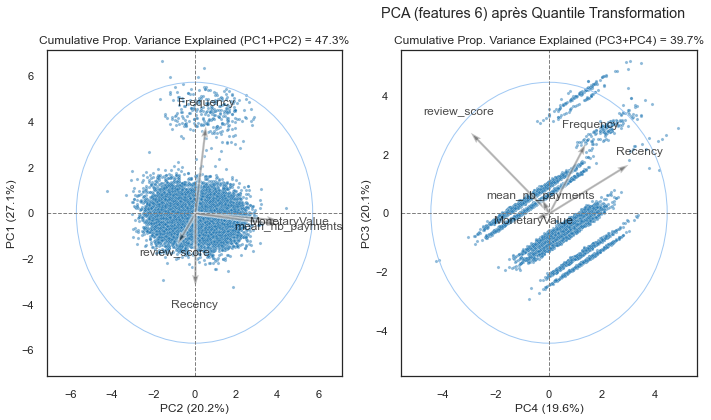

In [54]:
plot_clusters_on_pca(clients_quantiled[features_6], axis_ranks=[(
    0, 1), (2, 3), (4, 5)],  limit=50)
plt.suptitle('PCA (features 6) après Quantile Transformation')
to_png()


### Métriques de performance Kmeans

Pour évaluer le meilleur fit des clusters, on évaluera :

- **Distortion score** (inertia) : moyenne de la somme des **erreurs** (carrés) dans chaque cluster - chercher la coude
- **Davies-Bouldin score** : mesure de **forme** (homogénéité et séparation des clusters) - à **minimiser**
- **Calinski-Harabasz score** : distance intra cluster vs nearest cluster - à **maximiser**, ou chercher la coude de maximisation
- **Silhouette score** : une mesure de **cohérence** (appartenance à un cluster) - à **maximiser**

Le métrique par défaut de Kmeans et le distortion score

La **stabilité des clusters** est aussi un facteur à considérer dans le choix du meilleur cluster :

- soit par cross-validation sur des sous-ensembles de données
- soit par analyse de l'évolution des clusters dans le temps

La simulation et mesure de la stabilité des clusters prend beaucoup de temps de calcul et sera évalué dans [une autre notebook](./P5_03_simulation.ipynb)


#### Distortion scores

Le **distortion score** (inertia) est le somme des erreurs carrées dedans chaque cluster (_within Cluster SSE_)

On cherche l'optimal nombre de clusters qui réduit cette erreur, sans avoir

- trop de clusters - difficile d'interpreter
- des clusters qui se mélange (bas scores de Davies-Bouldin/ Silhouette)

Le choix d'optimal k est normalement fait avec **la méthode de coude** (Elbow method) - on choisit la valeur de k avec le plus grand angle entre les points


#### Meilleur forme des clusters (Calinski-Harabasz Score / Davies Bouldin Score)

#### Calinski-Harabasz score
The index is the ratio of the sum of between-clusters dispersion and of within-cluster dispersion for all clusters (where dispersion is defined as the sum of distances squared):

- On cherche une valeur le plus haut possible (**la méthode de coude**)
- si la ligne de descent n'a pas de coude, il n'y a pas une raison de préférer une valeur de k sur une autre valeur de k

Références

- <https://scikit-learn.org/stable/modules/clustering.html#calinski-harabasz-index>
- <https://stats.stackexchange.com/questions/52838/what-is-an-acceptable-value-of-the-calinski-harabasz-ch-criterion>


#### Meilleure cohérence des clusters (Silhouette Score)

- Les valeurs proches de 1 indique que les clusters sont denses est séparés
- Les valeurs proches de zero indique que les clusters se mélange
- Les valeurs moins de zero indique que les points peuvent être dans le mauvais cluster

Références:
- <https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html>
- <https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html>
- <https://towardsdatascience.com/are-you-solving-ml-clustering-problems-using-k-means-68fb4efa5469>

Utilisation de la bibliothèque 'yellowbrick' Pour faciliter la visualisation


"Yellowbrick_Silhouette_scores_visualisation.png"


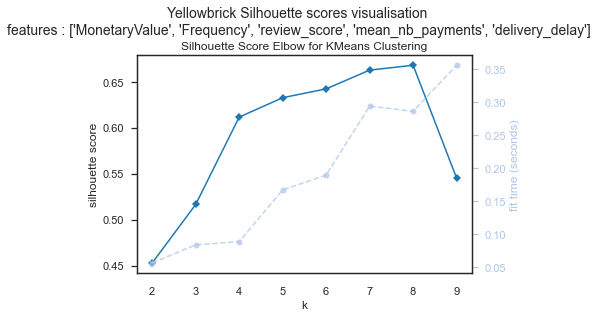

In [55]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model_elbow_vis = Pipeline(steps=[
    ('preprocessor', quantile_transformer),
    ('visualizer', KElbowVisualizer(
        KMeans(random_state=RANDOM_SEED), k=(2, 10), metric='silhouette', locate_elbow=False))
])
# avec 100,000 points, chaque silhouette score prend 2 minutes à calculer
sample_size=min(20000,len(clients))
model_elbow_vis.fit(clients[features_3].sample(
    sample_size, random_state=RANDOM_SEED))
model_elbow_vis.named_steps['visualizer'].finalize()
titre='Yellowbrick Silhouette scores visualisation'
plt.suptitle(f'{titre} \nfeatures : {features_3}', fontsize=14, y=1.05)
to_png(titre)


La calcule des Silhouette scores et très chronophage.
- Est-ce qu'on à vraiment besoin de toute les données pour calculer le moyenne silhouette score pour chaque donnée ?
- Quel est la taille d'echantillon nécessaire pour calculer le silhouette score avec confiance ?

"Silhouette_scores_pour_plusieurs_échantillons.png"


<Figure size 432x288 with 0 Axes>

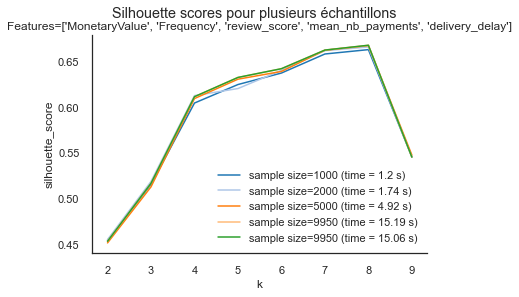

In [56]:
from yellowbrick.cluster import KElbowVisualizer
from time import time

def run_silhouette_visualizer(df: pd.DataFrame, n_samples=1000, k_range=(2, 10), ax=None, random_state=RANDOM_SEED):
    n_samples = min(n_samples, len(df))
    model = Pipeline(steps=[
        ('preprocessor', quantile_transformer),
        ('visualizer', KElbowVisualizer(
            KMeans(random_state=random_state), k=k_range, metric='silhouette',
            timings=False, locate_elbow=False, ax=ax, random_state=random_state))
    ])
    model.fit(df.sample(n_samples, random_state=random_state))
    visualizer: KElbowVisualizer = model.named_steps['visualizer']
    scores = pd.DataFrame({
        'k': visualizer.k_values_,
        'silhouette_score': visualizer.k_scores_,
    })
    visualizer.finalize()
    return scores


def plot_silhouettes_vs_k(df: pd.DataFrame, kmin=2, kmax=10):
    fig0, ax0 = plt.subplots(1, 1)
    fig1, ax1 = plt.subplots(1, 1)

    k_range = range(kmin, kmax)

    # 25 minutes pour complete data
    # for sample_size in [1000,2000,5000,10000,20000,50000,100000]:
    # < 30s
    for sample_size in [1000, 2000, 5000, 10000, 20000]:
        start = time()
        n_samples = min(sample_size, len(df))
        scores = run_silhouette_visualizer(df, n_samples=n_samples,
                                k_range=k_range, ax=ax0)
        calc_time = round((time()-start), 2)
        libelle = f'sample size={n_samples} (time = {calc_time} s)'
        sns.lineplot(data=scores, x='k', y='silhouette_score',
                     label=libelle, ax=ax1)

    fig0.clear()
    sns.despine()


plot_silhouettes_vs_k(clients[features_3], kmin=2, kmax=10)

plt.suptitle(f'Silhouette scores pour plusieurs échantillons')
plt.title(f'Features={features_3}')
to_png()


#### Le temps de calcul des silhouette_scores augment rapidement avec le nombre de points

Pour calculer le silhouette score, le temps de calcul est O(n^2)

- Avec 100000 points ça prends quelques minutes pour chaque valeur de k
- Avec 10000 points, c'est 100 fois plus rapide (quelque secondes), est la silhouette scores des clusters sont très similaires.

Pour augmenter le nombre d'essais de clustering, on fait l'analyse silhouette sur un sous-échantillon des données


In [57]:
from sklearn.cluster import KMeans
from sklearn import metrics


def performance_metrics(df: pd.DataFrame, labels, clf:KMeans, k, sample_size=10000, random_state=RANDOM_SEED):
    """
    Calculer les performance metrics pour un classifier (KMeans, DBSCAN, CAH etc)
    Parameters
    ----------
    scaled_df
    labels
    clf
    k
    sample_size
    random_state
 
    Returns
    -------

    """
    df = df.copy()
    n = min(len(df), sample_size)
    df['labels'] = labels
    df = df.sample(n=n, random_state=random_state)
    labels = df['labels'].values
    df = df.drop('labels', axis=1)
    res = {'k': k,
           'davies_bouldin': round(metrics.davies_bouldin_score(df, labels), 2),
           'calinski_harabasz': round(metrics.calinski_harabasz_score(df, labels), 2),
           'silhouette_score': round(metrics.silhouette_score(df, labels), 3)
           }
    if not clf is None:
        if hasattr(clf,'inertia_'):
            res['distortion_score']= round(clf.inertia_, 0)
    return res


In [58]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn import metrics
from time import time


def score_kmeans(df: pd.DataFrame, preprocessor: Pipeline = quantile_transformer, k_range=range(2, 10),
                 random_state=RANDOM_SEED, mini_batch=False, add_silhouette=True):
    """Fit les clusters et ajouter des scores sur un dataset"""
    df_scaled = preprocessor.fit_transform(df)

    scores = pd.DataFrame(
        {'k': [], 'distortion_score': [], 'fit time (s)': []})

    for k in k_range:
        if mini_batch:
            clf = MiniBatchKMeans(n_clusters=k, random_state=random_state)
        else:
            clf = KMeans(n_clusters=k, random_state=random_state)
        start_kmeans = time()
        clf.fit(df_scaled)
        fit_time_kmeans = round(time()-start_kmeans, 2)
        # inertia = distortion score = mean sum of squared distances to cluster centers
        res = {'k': k,
               'fit time (s)': fit_time_kmeans,
               'distortion_score': clf.inertia_,
               'davies_bouldin': metrics.davies_bouldin_score(df_scaled, clf.labels_),
               'calinski_harabasz': metrics.calinski_harabasz_score(df_scaled, clf.labels_)
               }

        if add_silhouette:
            # silhouette score basé sur une minimum de 2000 et un maximum de 20000 points
            # supposant que les clusters sont stables et seront approximativement les mêmes
            # plus de 20000 points prend trop de temps
            n_samples = min(2000, max(1000, len(df)//10))
            silh = []
            start_silh = time()
            for i in range(0, 10):
                df_sample = preprocessor.fit_transform(df.sample(n_samples))
                clf.fit(df_sample)
                silh.append(metrics.silhouette_score(df_sample, clf.labels_))
            res['silhouette_score'] = np.mean(silh)
            res['silhouette_score_std'] = np.std(silh)
            res['silhouette_sample_sizes'] = int(n_samples)
            res['silhouette_time'] = round(time()-start_silh, 2)

        scores = scores.append(res, ignore_index=True)
        scores['k'] = scores['k'].astype(int)
    return scores


essai_3_minibatch = score_kmeans(clients[features_3], preprocessor=quantile_transformer,
                                  random_state=RANDOM_SEED, mini_batch=True, add_silhouette=False)
essai_3_minibatch


k  distortion_score  fit time (s)  calinski_harabasz  davies_bouldin
0  2         140447.92          0.20            8298.22            1.06
1  3          95651.28          0.12            8415.76            0.83
2  4          51374.69          0.10           13303.68            0.69
3  5          44071.42          0.10           12042.89            0.61
4  6          32631.27          0.13           13711.52            0.68
5  7          25409.25          0.21           15157.69            0.64
6  8          24346.29          0.14           13613.68            0.83
7  9          22202.17          0.13           13191.86            0.95

In [59]:
# moins de 30 s
ESSAI_3 = 'Essai 3 : '
print(features_3)
essai_3 = score_kmeans(clients[features_3], preprocessor=quantile_transformer,
                        random_state=RANDOM_SEED, mini_batch=False, add_silhouette=True)

essai_3


['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'delivery_delay']


k  distortion_score  fit time (s)  calinski_harabasz  davies_bouldin  \
0  2         140374.60          0.07            8298.22            1.06   
1  3          88848.91          0.10            9438.88            0.72   
2  4          51362.68          0.11           13303.68            0.69   
3  5          42735.02          0.13           12492.88            0.65   
4  6          32599.05          0.23           13718.87            0.66   
5  7          25372.18          0.29           15159.28            0.64   
6  8          22818.67          0.31           14605.20            0.69   
7  9          21474.98          0.46           13655.98            0.90   

   silhouette_sample_sizes  silhouette_score  silhouette_score_std  \
0                  1000.00              0.45                  0.00   
1                  1000.00              0.51                  0.01   
2                  1000.00              0.61                  0.01   
3                  1000.00              0.63                  0.00   
4                  1000.00              0.64                  0.01   
5                  1000.00              0.66                  0.00   
6                  1000.00              0.66                  0.00   
7                  1000.00              0.56                  0.04   

   silhouette_time  
0             1.55  
1             1.59  
2             1.68  
3             1.80  
4             1.90  
5             2.00  
6             2.13  
7             2.25

On voit que _MiniBatchKmeans_ est beaucoup plus rapide que _KMeans_ mais les résultats sont presque identiques


"Essai_3_-__Comparaison_de_KMeans_et_Minibatch_KMeans.png"


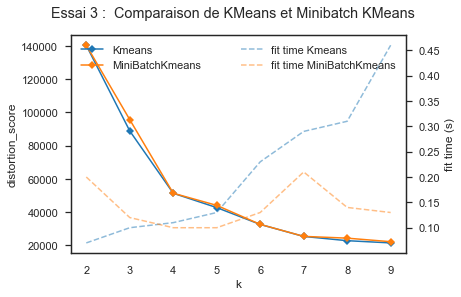

"Essai_3_-__Comparaison_de_KMeans_et_Minibatch_KMeans_(db).png"


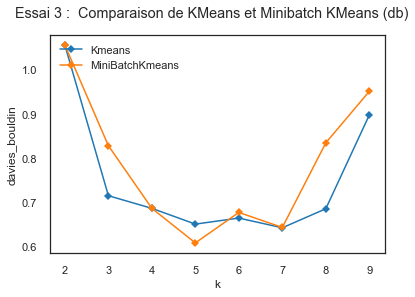

In [143]:
def plot_compare_essais(scores_1,scores_2, 
metric='distortion_score', time_col='fit time (s)', 
label_1='Scores 1', label_2='Scores 1'):
    colors=sns.color_palette('tab10').as_hex()
    _, ax_score = plt.subplots()
    ax_score.plot(scores_1['k'], scores_1[metric],
                marker='D', label=label_1,color=colors[0])
    ax_score.plot(scores_2['k'], scores_2[metric],
                marker='D', label=label_2, color=colors[1])
    ax_score.set_xlabel('k')
    ax_score.set_ylabel(metric)
    plt.legend(loc=2)
    if not (time_col is None):
        ax_time = ax_score.twinx()
        ax_time.plot(essai_3['k'], scores_1[time_col],
                    label=f'fit time {label_1}', ls='--', color=colors[0],alpha=0.5)
        ax_time.plot(scores_2['k'], scores_2[time_col],
                    label=f'fit time {label_2}', ls='--', color=colors[1],alpha=0.5)
        ax_time.set_ylabel('fit time (s)')
        plt.legend(loc=1)

plot_compare_essais(essai_3,essai_3_minibatch, 
label_1='Kmeans',label_2='MiniBatchKmeans')
plt.suptitle(f'{ESSAI_3} Comparaison de KMeans et Minibatch KMeans')
to_png()
plt.show()

plot_compare_essais(essai_3,essai_3_minibatch, 
label_1='Kmeans',label_2='MiniBatchKmeans',
metric='davies_bouldin', time_col=None)
plt.suptitle(f'{ESSAI_3} Comparaison de KMeans et Minibatch KMeans (db)')
to_png()


Même si MiniBatch KMeans est plus rapide, les scores sont moins confiables

### Plot metrics

Forme


In [61]:
def angle_between_vectors(v1, v2):
    """
    calculate angle between 2 vectors.
    use to find elbow
    """
    ang1 = np.arctan2(*v1[::-1])
    ang2 = np.arctan2(*v2[::-1])
    ang = np.rad2deg(abs(ang1 - ang2) % (2 * np.pi))
    if ang > 180:
        ang = ang-180
    return ang

print([
    angle_between_vectors([1,1],[0,0]),
    angle_between_vectors([1,1],[0,1]),
    angle_between_vectors([1,1],[-1,0]),
    angle_between_vectors([1,1],[-1,-1]),
])

[45.0, 45.0, 135.0, 180.0]


In [62]:

def find_elbow(df: pd.DataFrame, x_col='k', y_col='distortion_score'):
    """find sharpest difference in angle for [k, score]"""
    df = df.copy().reset_index()
    # standardise scale to maximise angles between points
    
    x_scale=df[x_col].max()-df[x_col].min()
    y_min = df[y_col].min()
    y_mult = (df[y_col].max()-y_min)/x_scale
    df['y_scaled'] = (df[y_col]-y_min)/y_mult

    # calculate angles between consecutive points
    n = len(df)
    for i in range(0, n-2):
        point1 = df.loc[i, [x_col, 'y_scaled']]
        point2 = df.loc[i+1, [x_col, 'y_scaled']]
        point3 = df.loc[i+2, [x_col, 'y_scaled']]
        vec1 = point2-point1
        vec2 = point3-point2
        df.loc[i+1, 'angle'] = angle_between_vectors(vec1, vec2)
    # elbow is at highest difference in angle (assume monotonic function)
    row = df['angle'].idxmax()
    x_elbow = df.loc[row, x_col]
    y_score = df.loc[row, y_col]
    return x_elbow, y_score

k_best, distortion_score = find_elbow(essai_3, y_col='distortion_score')
print(f'{ESSAI_3} Best score for k = {k_best}')

Essai 3 :  Best score for k = 4


"Essai_3_-__Kmeans_Distortion_Score.png"


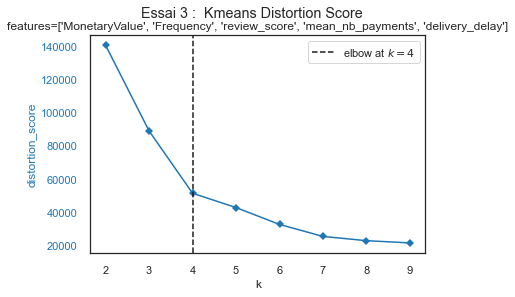

In [144]:
def plot_second_ax(df,x_col,y2_col, ax, color='grey'):
    if y2_col in df.columns:
        ax2 = ax.twinx()
        ax2.plot(df[x_col], df[y2_col], label=y2_col,
                    c=color, marker='o', linestyle='--', alpha=0.75)
        ax2.tick_params(axis='y', colors=color)
        ax2.set_ylabel(y2_col, color=color)

def plot_elbow(df,x_col,y_col, ax):
        elbow_k, elbow_score = find_elbow(df, x_col, y_col)
        elbow_label = f'elbow at ${x_col}={elbow_k}$'
        ax.axvline(elbow_k, c='k', linestyle="--", label=elbow_label)
        ax.legend(frameon=True)

def plot_vline(df,x_col,y_col,ax, line_at='max'):
    if line_at=='max':
        row_idx= df[y_col].argmax()
    elif line_at =='min':
        row_idx=df[y_col].argmin()
    line_x = df.loc[row_idx,x_col]
    line_label = f'{line_at} at ${x_col}={line_x}$'
    ax.axvline(line_x, c='k', linestyle="--", label=line_label)
    ax.legend(frameon=True)


def plot_elbow_visualiser(df: pd.DataFrame, x_col='k',score_col='distortion_score',
  show_elbow=False, time_col=None, ax1=None):
    colors = sns.color_palette("tab20").as_hex()
    if ax1 is None:
        _, ax1 = plt.subplots()
    # scores
    ax1.plot(df[x_col], df[score_col],
             marker="D", c=colors[0], linestyle="-")
    ax1.grid(False)
    ax1.tick_params(axis='y', colors=colors[0])
    ax1.set_xlabel(x_col)
    ax1.set_ylabel(score_col, c=colors[0])
    # fit times
    if not time_col is None:
        plot_second_ax(df,x_col,y2_col=time_col,ax=ax1)
    if show_elbow:
        plot_elbow(df,x_col,score_col, ax1)

## Test visualiser
plot_elbow_visualiser(essai_3, score_col='distortion_score',show_elbow=True)
plt.suptitle(f'{ESSAI_3} Kmeans Distortion Score')
plt.title(f'features={features_3}')
to_png()


### Plot summary metrics

"Essai_3_-__performance_metrics.png"


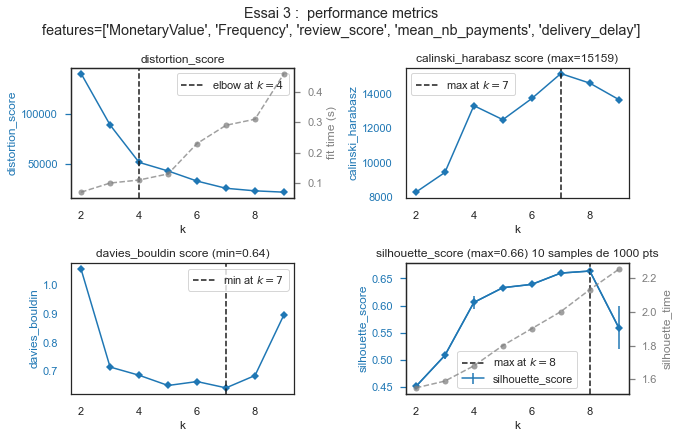

In [65]:
def plot_metrics(df_scores):
    METRICS = ['distortion_score', 'calinski_harabasz','davies_bouldin', 'silhouette_score']
    metrics = cols_in_df(df_scores,METRICS)
    n_plots= len(metrics)
    n_cols=min(n_plots,2);
    # n_rows = int(ceil(n_plots/n_cols))
    n_rows = n_plots// n_cols + (n_plots % n_cols > 0)
    _ = plt.figure(figsize=(n_cols*5, n_rows*3))
    for n, metric in enumerate(metrics):
        ax = plt.subplot(n_rows, n_cols, n + 1)
        if metric=='distortion_score':
            plot_elbow_visualiser(df_scores,'k',metric,ax1=ax,time_col='fit time (s)', show_elbow=True)
            plt.title(metric)
        if metric=='calinski_harabasz':
            plot_elbow_visualiser(df_scores,'k',metric,ax1=ax)
            plot_vline(df_scores,'k',metric,ax=ax,line_at='max')
            plt.title(f'{metric} score (max={df_scores[metric].max():.0f})')
        if metric=='davies_bouldin':
            plot_elbow_visualiser(df_scores,'k',metric,ax1=ax)
            plot_vline(df_scores,'k',metric,ax=ax,line_at='min')
            plt.title(f'{metric} score (min={df_scores[metric].min():.2f})')
        if metric=='silhouette_score':
            titre=f'{metric} (max={df_scores[metric].max():.2f})'
            if 'silhouette_score_std' in df_scores.columns:
                if 'silhouette_sample_sizes' in df_scores.columns:
                    sample_size=int(df_scores['silhouette_sample_sizes'].max())
                    titre += f' 10 samples de {sample_size} pts' 
                plt.errorbar(data=df_scores, x='k', y='silhouette_score',
                    yerr='silhouette_score_std')
            plot_elbow_visualiser(df_scores,'k',metric,ax1=ax,time_col='silhouette_time')
            plot_vline(df_scores,'k',metric,ax=ax,line_at='max')
            plt.title(titre)

    plt.subplots_adjust(hspace=0.5, wspace=0.5)

plot_metrics(essai_3)
titre=f'{ESSAI_3} performance metrics'
plt.suptitle(f'{titre}\nfeatures={features_3}', y=1.02)
to_png(titre)


"Essai_3_-__(quantile_pca_prep)_performance_metrics.png"


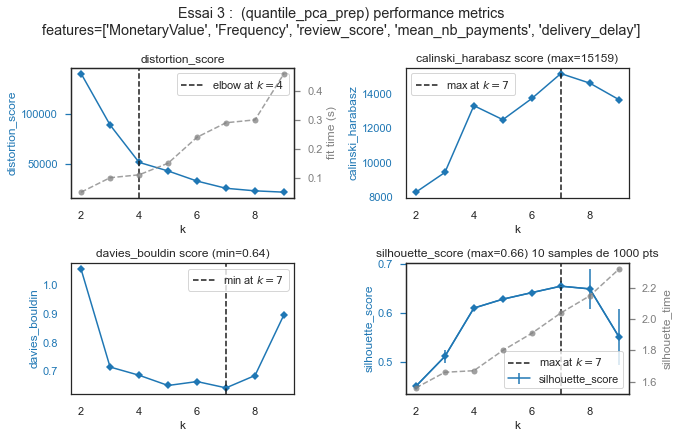

In [66]:
pca_preprocessor = Pipeline(steps=[
    ('scale', QuantileTransformer(
        output_distribution='normal', random_state=RANDOM_SEED)),
    ('pca', PCA())
])
essai_3b = score_kmeans(clients[features_3], preprocessor=pca_preprocessor,
                         random_state=RANDOM_SEED, mini_batch=False, add_silhouette=True)

plot_metrics(essai_3b)
titre=f'{ESSAI_3} (quantile_pca_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={features_3}', y=1.02)
to_png(titre)


"Essai_3_-__Minibatch_KMeans_(quantile_pca_prep)_performance_metrics.png"


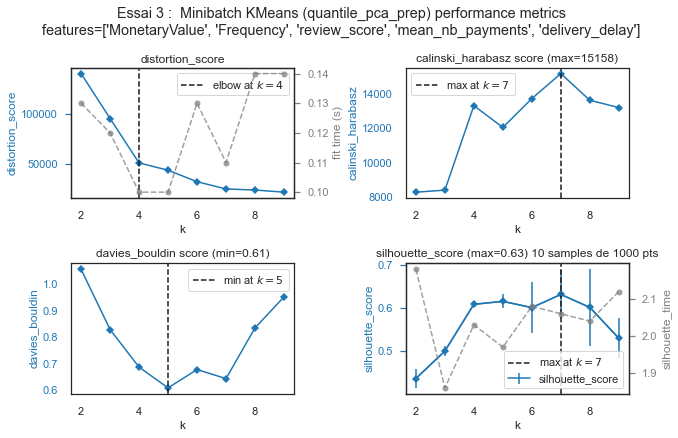

In [67]:
essai_3c = score_kmeans(clients[features_3], preprocessor=pca_preprocessor,
                         random_state=RANDOM_SEED, mini_batch=True, add_silhouette=True)

plot_metrics(essai_3c)
titre=f'{ESSAI_3} Minibatch KMeans (quantile_pca_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={features_3}', y=1.02)
to_png(titre)

"Essai_3_-__KMeans_(standard_scalar_prep)_performance_metrics.png"


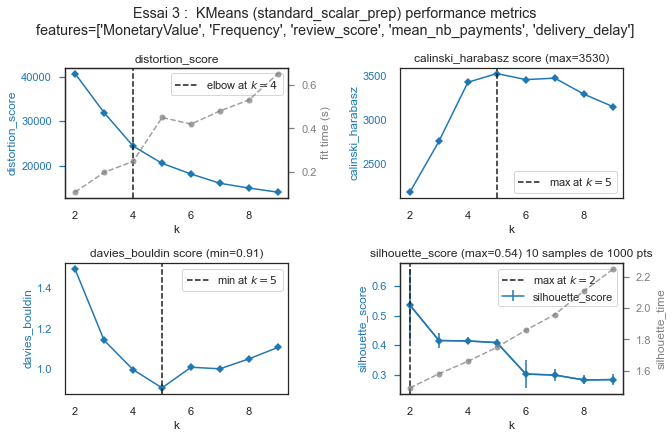

In [68]:
essai_3d = score_kmeans(clients[features_3], preprocessor=StandardScaler(),
                         random_state=RANDOM_SEED, mini_batch=False, add_silhouette=True)

plot_metrics(essai_3d)
titre=f'{ESSAI_3} KMeans (standard_scalar_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={features_3}', y=1.02)
to_png(titre)

['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'products_per_order']
"Essai_4_-__(quantile_prep)_performance_metrics.png"


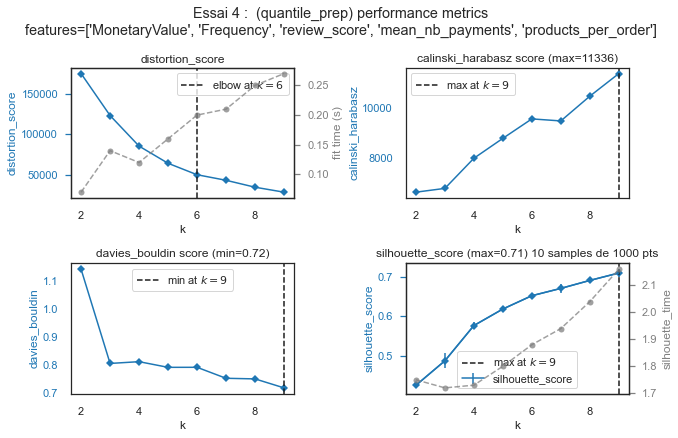

In [69]:
ESSAI_4 = 'Essai 4 : '
print(features_4)
essai_4 = score_kmeans(clients[features_4], preprocessor=quantile_transformer,
                        random_state=RANDOM_SEED, mini_batch=False, add_silhouette=True)

plot_metrics(essai_4)
titre=f'{ESSAI_4} (quantile_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={features_4}', y=1.02)
to_png(titre)

['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'products_per_order', 'delivery_delay']
"Essai_4b_-__(quantile_prep)_performance_metrics.png"


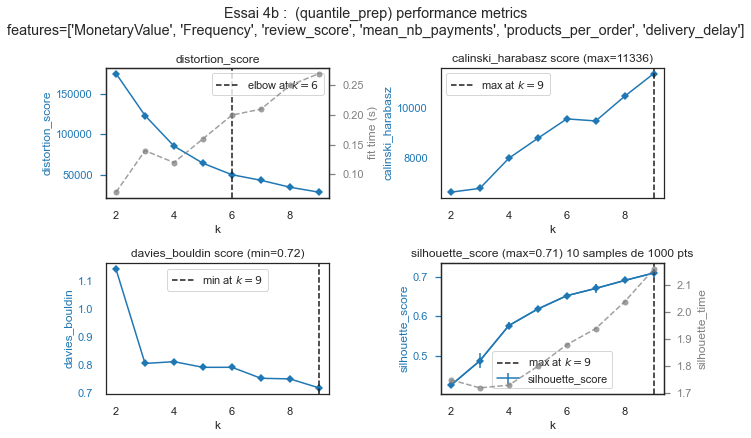

In [70]:
ESSAI_4b = 'Essai 4b : '
features_4b = ['MonetaryValue', 'Frequency', 'review_score',
               'mean_nb_payments', 'products_per_order', 'delivery_delay']
print(features_4b)
essai_4b = score_kmeans(clients[features_4b], preprocessor=quantile_transformer,
                         random_state=RANDOM_SEED, mini_batch=False, add_silhouette=True)

plot_metrics(essai_4)
titre=f'{ESSAI_4b} (quantile_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={features_4b}', y=1.02)
to_png(titre)

['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'products_per_order', 'Recency']
"Essai_5_-__(quantile_prep)_performance_metrics.png"


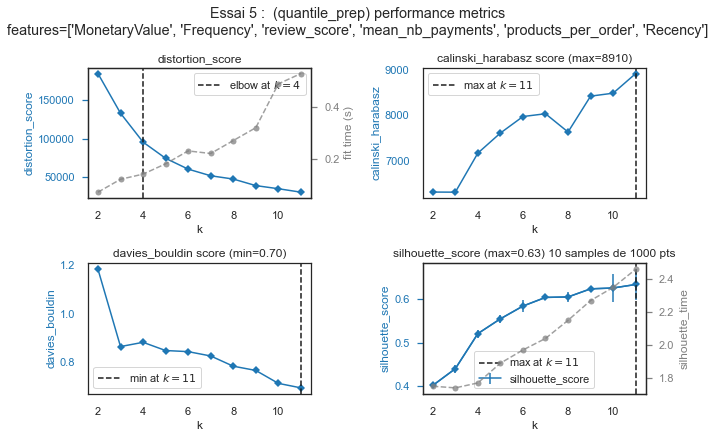

In [71]:
ESSAI_5 = 'Essai 5 : '
print(features_5)
essai_5 = score_kmeans(clients[features_5], preprocessor=quantile_transformer, k_range=range(2, 12),
                        random_state=RANDOM_SEED, mini_batch=False, add_silhouette=True)

plot_metrics(essai_5)
titre=f'{ESSAI_5} (quantile_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={features_5}', y=1.02)
to_png(titre)


['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'Recency']
"Essai_6_-__(quantile_prep)_performance_metrics.png"


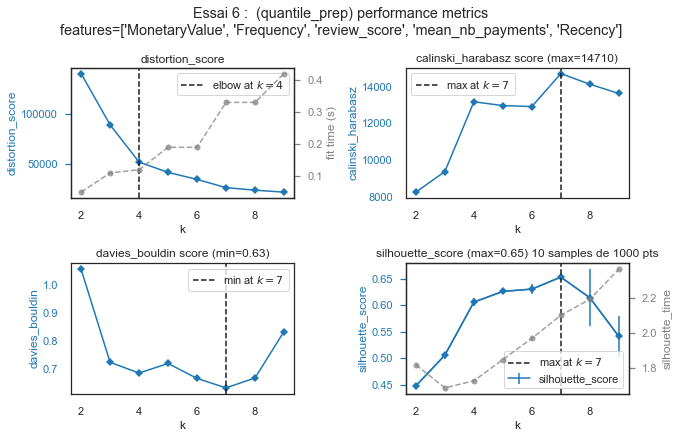

In [72]:
ESSAI_6 = 'Essai 6 : '
print(features_6)
essai_6 = score_kmeans(clients[features_6], preprocessor=quantile_transformer,
                        random_state=RANDOM_SEED, mini_batch=False, add_silhouette=True)

plot_metrics(essai_6)
titre=f'{ESSAI_6} (quantile_prep) performance metrics'
plt.suptitle(f'{titre}\nfeatures={features_6}', y=1.02)
to_png(titre)


In [73]:
k_best=7
print(k_best)


7


#### Visualisation des distances entre clusters


Text(0.5, 0.98, 'Essai 3 :  Distance(MDS) for k = 7')

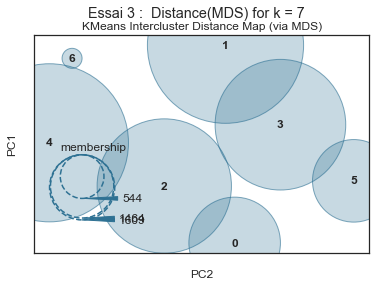

In [74]:
from yellowbrick.cluster import InterclusterDistance
from sklearn.cluster import KMeans, MiniBatchKMeans
model_vis = Pipeline(steps=[
    ('preprocessor', quantile_transformer),
    ('visualizer', InterclusterDistance(
        KMeans(random_state=RANDOM_SEED, n_clusters=k_best)))
])

model_vis.fit(clients[features_3])
model_vis.named_steps['visualizer'].finalize()
plt.suptitle(f'{ESSAI_3} Distance(MDS) for k = {k_best}')


"Essai_3_-__Distance(t-SNE)_for_k_=_7.png"


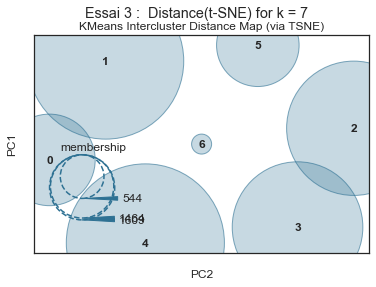

In [75]:
from yellowbrick.cluster import InterclusterDistance
from sklearn.cluster import KMeans
model_vis_tsne = Pipeline(steps=[
    ('preprocessor', quantile_transformer),
    ('visualizer', InterclusterDistance(
        KMeans(n_clusters=k_best, random_state=RANDOM_SEED,), embedding='tsne'))
])
model_vis_tsne.fit(clients[features_3])
model_vis_tsne.named_steps['visualizer'].finalize()
plt.suptitle(f'{ESSAI_3} Distance(t-SNE) for k = {k_best}')
to_png()


On voit que le silhouette score est meilleur avec 4 clusters


### Silhouette visualisation

On cherche non seulement un bonne score silhouette moyenne, mais que chaque cluster à un bonne silhouette score.

- <https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html>
- <https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html>
- <https://towardsdatascience.com/are-you-solving-ml-clustering-problems-using-k-means-68fb4efa5469>


Silhouette_score for 8 clusters : 0.668


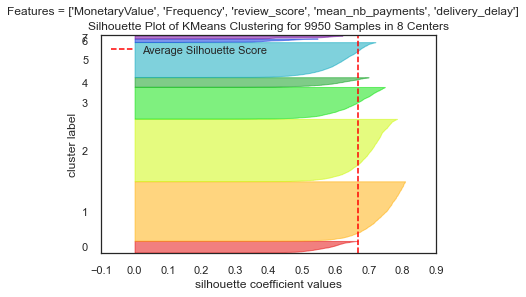

In [76]:
from yellowbrick.cluster import SilhouetteVisualizer


def plot_silhouettes(df: pd.DataFrame, k_clusters=7, preprocessor=quantile_transformer):

    cluster_colors = sns.color_palette('nipy_spectral_r', n_colors=k_clusters)
    estimator = KMeans(n_clusters=k_clusters, random_state=RANDOM_SEED)
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('visualizer', SilhouetteVisualizer(estimator, colors=cluster_colors))
    ])

    n_samples = min(20000, len(clients))
    model.fit(df.sample(n_samples, random_state=RANDOM_SEED))
    visualizer: SilhouetteVisualizer = model.named_steps['visualizer']

    # ~ 5 minutes
    visualizer.finalize()        # Finalize and render the figure
    print(
        f'Silhouette_score for {k_clusters} clusters : {visualizer.silhouette_score_:.3f}')
    plt.suptitle(f'Features = {features_3}', fontsize=12)


plot_silhouettes(clients[features_3], k_clusters=8)


Silhouette_score for 7 clusters : 0.663


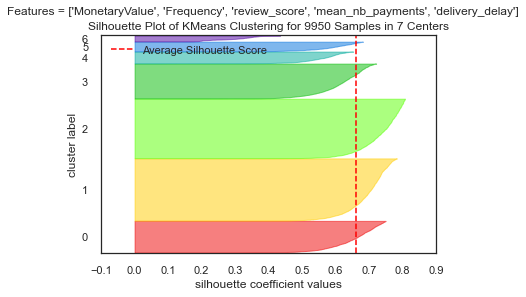

In [77]:
plot_silhouettes(clients[features_3], k_clusters=7)


Silhouette_score for 6 clusters : 0.642


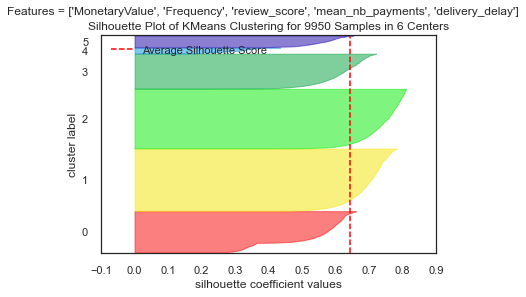

In [78]:
plot_silhouettes(clients[features_3], k_clusters=6)


Silhouette_score for 5 clusters : 0.633


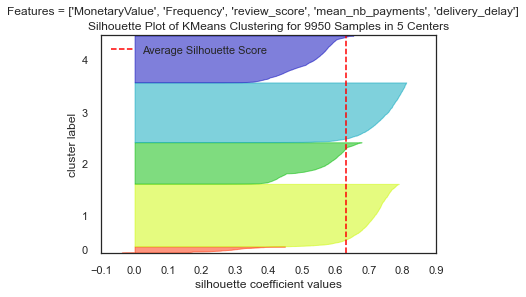

In [79]:
plot_silhouettes(clients[features_3], k_clusters=5)


Les résultats de l'analyse Silhouette

- les clusters sont assez équivalents en taille
- les clusters sont denses et séparées


In [80]:
k_best = 8


## Procedures pour automatiser la fit, metrics, aggregation des clusters

- run_fit_model
- run_predict_model
- calc_metrics
- group_clusters

**SOLID principles**: single responsibility, open to extension, replaceable, ...

### Run Fit Model

In [81]:
from sklearn.base import BaseEstimator
from copy import deepcopy
FEATURES = ['Frequency', 'MonetaryValue',
            'review_score', 'mean_nb_payments', 'delivery_delay']


def run_fit_model(df:pd.DataFrame, model_:BaseEstimator, features=FEATURES, k=7,
                  remove_outliers_during_fit=True, percent_outliers=0.005,
                  random_state=RANDOM_SEED)->pd.DataFrame:
    """
    Run classification model sur les features selectionnées

    Parameters
    ----------
    df      données à classifier
    model_  un pipeline de clustering, avec 'clf' comme named step qui contient l'estimator
    features subset de colonnes de df à prendre en compte pendant le fit  

    Returns
    -------
    données, plus une colonne qui contient les cluster labels
    """
    
    df = df.copy()

    # Eliminer des outliers avant fit
    if percent_outliers<=0:
        remove_outliers_during_fit=False
 
    if remove_outliers_during_fit:
        # trouver outliers seulement dans les features utilisés pour fit model
        df = df.pipe(find_outliers, num_cols=features,
                     alpha=percent_outliers, random_state=random_state)
        df_outliers = df[df['outlier'] == 'yes']
        df = df[df['outlier'] != 'yes']

    # Définir nombre de clusters
    # s'il y a d'autre parametres, 
    # appliquer model.set_params(...) avant de passer le model à ce procedure
    if not k is None:
        # certain clustering ne permet pas de definir le nombre de clusters
        params = {'clf__n_clusters': k}
        model_.set_params(**params)

    # fit les clusters    
    model_.fit(df[features])

    clf = model_.named_steps['clf']
    if hasattr(clf,'labels_'):
        # pas besoin de predict - il est déjà fait
        df['cluster_id'] = clf.labels_
    else:
        df['cluster_id'] = model_.predict(df[features])

    if remove_outliers_during_fit:
        # predict les outliers, et ajouter au résultats
        df_outliers['cluster_id'] = model_.predict(df_outliers[features])
        df = df.append(df_outliers, ignore_index=False)

    return df, deepcopy(model_)


def run_predict_model(df, fitted_model, features=FEATURES):
    df = df.copy()
    df['cluster_id'] = fitted_model.predict(df[features])
    return df


In [82]:
def get_metrics(df, features, preprocessor=None, clf=None, cluster_col=CLUSTER_COL):
    if preprocessor is None:
        preprocessor=QuantileTransformer(output_distribution='normal')
    df_scaled = pd.DataFrame(
                preprocessor.fit_transform(df[features]),
                index=df.index,
                columns=features)
    metr = performance_metrics(df_scaled, df[cluster_col], clf=clf, k=df[cluster_col].nunique())
    return metr

### Calculer les moyennes pour chaque cluster


In [83]:
def drop_cluster_labels(df: pd.DataFrame, cluster_col=CLUSTER_COL):
    if cluster_col in df.columns:
        return df.drop(cluster_col, axis=1)
    return df


In [84]:
pre_quant_normal = QuantileTransformer(output_distribution='normal',random_state=RANDOM_SEED)
model_kmeans_quant_normal = Pipeline(steps=[
    ('preprocessor', pre_quant_normal),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
])

clients_clusters, _= run_fit_model(df_clients,model_kmeans_quant_normal,features_3, k=7)
cluster_means=group_clusters(clients_clusters)
cluster_means[[CLUSTER_COL, 'cluster_size', 'cluster_pct', *features_3]]


cluster_id  cluster_size  cluster_pct  MonetaryValue  Frequency  \
0          5           567         5.67         232.26       1.01   
1          2          2876        28.76         198.62       1.00   
2          1          1616        16.16         195.57       1.00   
3          6           279         2.79         152.27       2.11   
4          3           453         4.53         143.60       1.01   
5          4          1464        14.64         117.35       1.00   
6          0          2745        27.45         114.02       1.00   

   review_score  mean_nb_payments  delivery_delay  
0          1.00              5.06           -3.56  
1          5.00              4.70          -13.20  
2          3.54              4.66          -11.02  
3          4.33              3.18          -12.23  
4          1.00              1.00           -1.81  
5          3.58              1.00          -10.32  
6          5.00              1.00          -12.48

## Interpretation des clusters


### 2D Scatter plot des clusters


Text(0.5, 0.98, 'Essai 3 :  review_score vs. MonetaryValue')

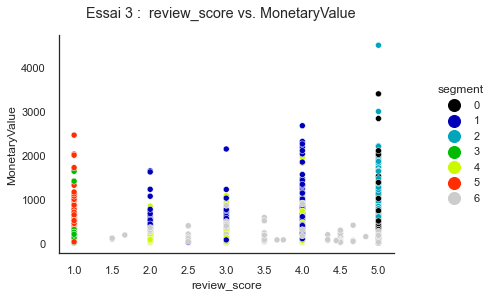

In [85]:
def plot_clusters_2D(df: pd.DataFrame, x_col=None, y_col=None, cluster_col=CLUSTER_COL, ax=None):
    sns.scatterplot(data=df, x=x_col, y=y_col,
                    hue=cluster_col, hue_order=calc_cluster_order(df),palette='nipy_spectral', ax=ax)
    sns.despine()
    plt.legend(title='segment', bbox_to_anchor=(
        1.3, 0.5), loc=5, markerscale=2)


plot_clusters_2D(clients_clusters, 'review_score', 'MonetaryValue')
plt.suptitle(f'{ESSAI_3} review_score vs. MonetaryValue')


### Boxplots des clusters


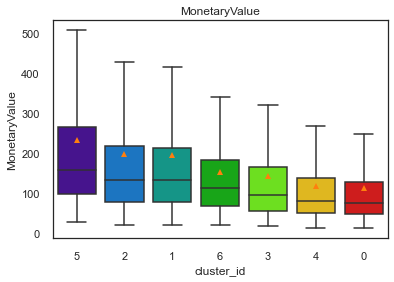

In [86]:
def plot_box_clusters(df: pd.DataFrame, y_col, cluster_col=CLUSTER_COL, ax=None):
    if y_col in df.columns:
        ax = sns.boxplot(data=df, x=cluster_col, y=y_col, order=calc_cluster_order(df), ax=ax,
                         showfliers=False, showmeans=True, palette='nipy_spectral')
        ax.set_title(y_col)


plot_box_clusters(clients_clusters, 'MonetaryValue')


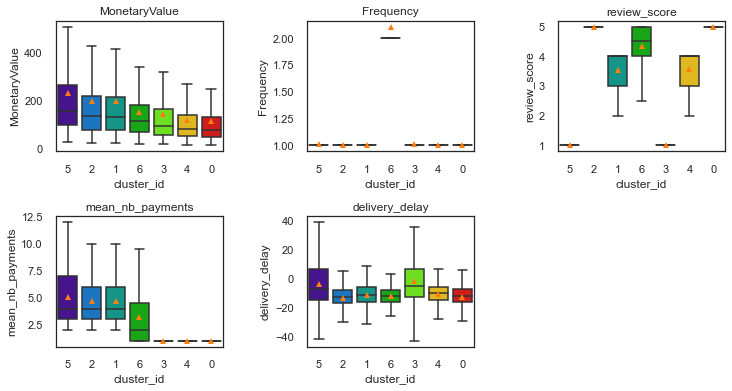

In [87]:
def plot_box_features(df: pd.DataFrame, features):
    n_cols = 3
    n_rows = len(features) // n_cols + (len(features) % n_cols > 0)
    # n_clusters= df[CLUSTER_COL].nunique()
    _ = plt.figure(figsize=(n_cols*4, n_rows*3))
    for n, feature in enumerate(features):
        ax = plt.subplot(n_rows, n_cols, n + 1)
        plot_box_clusters(df=df, y_col=feature, ax=ax)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)


plot_box_features(clients_clusters, features_3)


### Snake plots (comparison de plusieurs variables)

Pour avoir les données au même echelle, on applique le MinMaxScalar sur les means de chaque cluster

Define une échelle entre 1 à 5 pour afficher les radar plots / snake plots

In [88]:
def standard_scores(df,features=FEATURES,cluster_col=CLUSTER_COL, scaler=None,min_score=1,max_score=5):
    # Data Standardisation
    if scaler is None:
        scaler=MinMaxScaler(feature_range=(min_score,max_score))
    df_std = pd.DataFrame(scaler.fit_transform(df[features]),
                                  columns=list(df[features].columns),
                                  index=df[features].index)

    # Concatenating the cluster label
    df_std = pd.concat(
        [df_std, df[[cluster_col, 'cluster_pct']]], axis=1)
    df_std = df_std[[cluster_col, 'cluster_pct', *features]]
    if VALUE_COL in df_std.columns:
        df_std = df_std.sort_values(
            by=VALUE_COL, ascending=False)
    return df_std

In [89]:
print(cluster_means.columns)
standard_scores(cluster_means)

Index(['cluster_id', 'cluster_size', 'cluster_pct', 'Frequency',
       'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score',
       'delivery_time', 'delivery_delay', 'distance_customer_seller',
       'freight_percent', 'time_of_day', 'weekday', 'products_per_order',
       'customer_unique_id', 'dernier_achat', 'payment_mode',
       'favourite_category', 'outlier'],
      dtype='object')


cluster_id  cluster_pct  Frequency  MonetaryValue  review_score  \
0          5         5.67       1.05           5.00          1.00   
1          2        28.76       1.00           3.86          5.00   
2          1        16.16       1.00           3.76          3.54   
3          6         2.79       5.00           2.29          4.33   
4          3         4.53       1.05           2.00          1.00   
5          4        14.64       1.00           1.11          3.58   
6          0        27.45       1.00           1.00          5.00   

   mean_nb_payments  delivery_delay  
0              5.00            4.39  
1              4.65            1.00  
2              4.61            1.77  
3              3.15            1.34  
4              1.00            5.00  
5              1.00            2.01  
6              1.00            1.26

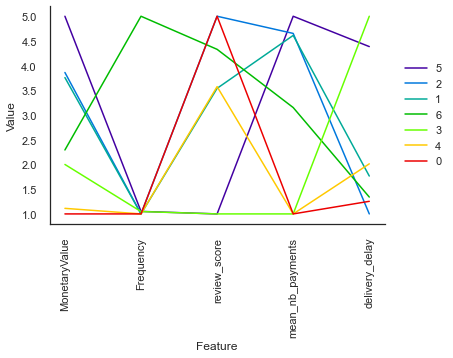

In [90]:
def plot_snake(df: pd.DataFrame, features=FEATURES, cluster_col=CLUSTER_COL):
    df_std = standard_scores(df, features)
    melt_cols=[*features,cluster_col]
    df_melt = pd.melt(df_std[melt_cols],[cluster_col],
                      var_name='Feature', value_name='Value')
    plt.figure()
    sns.lineplot(data=df_melt, x='Feature', y='Value',
                 hue=cluster_col, hue_order=calc_cluster_order(df),
                 palette=CLUSTER_PALETTE)
    plt.xticks(rotation=90)
    sns.despine()
    plt.legend(bbox_to_anchor=(1.2, 0.5), loc=5)

plot_snake(cluster_means, features_3)

### Spider plots

Pour avoir les données au même echelle, on applique le MinMaxScalar sur les means de chaque cluster, avec un range de 1 à 5
- (n'utilise pas min = 0 : le spider devient invisible)


[5, 2, 1, 6, 3, 4, 0]


({'k': 7,
  'davies_bouldin': 0.64,
  'calinski_harabasz': 15197.32,
  'silhouette_score': 0.663},
 {'seg 0': 5.67,
  'seg 1': 28.76,
  'seg 2': 16.16,
  'seg 3': 2.79,
  'seg 4': 4.53,
  'seg 5': 14.64,
  'seg 6': 27.45})

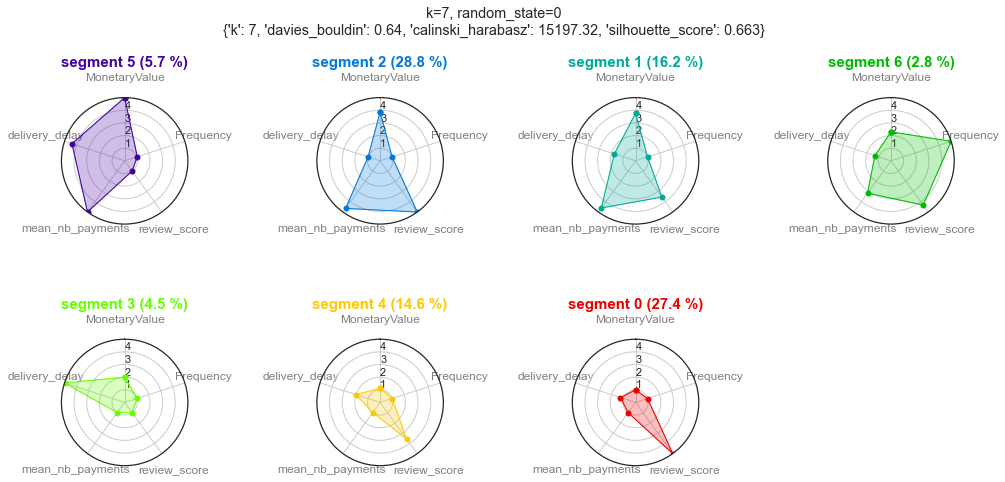

In [92]:
from math import pi, ceil
from matplotlib.figure import Figure
from matplotlib.projections import PolarAxes

def plot_spider(df: pd.DataFrame, features, cluster_col=CLUSTER_COL):
    df_to_plot_std=standard_scores(df,features,cluster_col,min_score=1,max_score=5)
    n_clusters = df[cluster_col].nunique()

    color = sns.color_palette('nipy_spectral', n_colors=n_clusters)

    # angles
    n_features = len(features)
    angles = [n / float(n_features) * 2 * pi for n in range(n_features)]
    angles += angles[:1]  # close plot

    n_cols = 4
    # n_rows = int(ceil(n_clusters/n_cols))
    n_rows = n_clusters // n_cols + (n_clusters % n_cols > 0)
    fig: Figure = plt.figure(1, figsize=(n_cols*4, n_rows*4))

    # segments=sorted(list(df_clusters[cluster_col].unique()))
    segments = list(df_to_plot_std[cluster_col])
    print(segments)

    for i, segment in enumerate(segments):
        ax: PolarAxes = fig.add_subplot(n_rows, n_cols, i + 1, polar=True)

        # We are going to plot the first line of the data frame.
        values = list(df_to_plot_std.loc[i][features].values)
        values += values[:1]  # repeat 1st feature to close radar plot
        pct = df_to_plot_std.loc[i]['cluster_pct']
        ax.set_title(f'segment {segment} ({pct:.1f} %)', color=color[i], fontdict={
                     "fontsize": 15, "fontweight": "bold"})
        ax.set_theta_offset(pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(0)

        # Draw one axe per variable + add labels
        plt.xticks(angles[:-1], features, color="grey", size=8)
        ax.set_xticklabels(features, size=12)

        # Draw ylabels
        ax.set_rlabel_position(0)
        ax.set_rlim((0, 5))
        # r axis is a transformation of the y_axis
        # ax.set_ylim((0,5))
        ax.set_rgrids(range(1, 5))

        # Plot data
        ax.plot(angles, values, color=color[i], marker="o", lw=1, ls="solid")

        # Fill area
        ax.fill(angles, values, color=color[i], alpha=.25)
        plt.subplots_adjust(hspace=0.25, wspace=1.02)

    pct = df_to_plot_std['cluster_pct'].to_dict()
    pct = {f'seg {k}': v for k, v in pct.items()}
    # pct = pd.DataFrame({f'seg {k}': v for k, v in pct.items()})

    return pct

def run_fit_spider(df=df_clients, features=FEATURES,model=None,k=7, random_state=RANDOM_SEED):
    if model is None:
        # model=Pipeline([
        #     ('preprocessor',QuantileTransformer(output_distribution='normal')),
        #     ('clf',KMeans(n_clusters=k))
        # ])
        model = Pipeline(steps=[
            ('preprocessor', QuantileTransformer(output_distribution='normal',random_state=random_state)),
            ('clf', KMeans(n_clusters=7, random_state=random_state))
        ])
    clusters, _ =run_fit_model(df,model, features, k=k)
    cluster_means=group_clusters(clusters)
    pct=plot_spider(cluster_means,features_3)
    preprocessor=model.named_steps['preprocessor']
    clf=model.named_steps['preprocessor']
    metr=get_metrics(clusters,features,preprocessor,clf)
    titre = f'k={k}, random_state={random_state}'
    plt.suptitle(f'{titre}\n{metr}')
    return metr,pct
    
run_fit_spider(df_clients, features_3, k=7)


[4, 5, 1, 0, 6, 3, 2]


({'k': 7,
  'davies_bouldin': 0.83,
  'calinski_harabasz': 7983.81,
  'silhouette_score': 0.602},
 {'seg 0': 5.21,
  'seg 1': 4.57,
  'seg 2': 18.56,
  'seg 3': 26.08,
  'seg 4': 2.83,
  'seg 5': 17.17,
  'seg 6': 25.58})

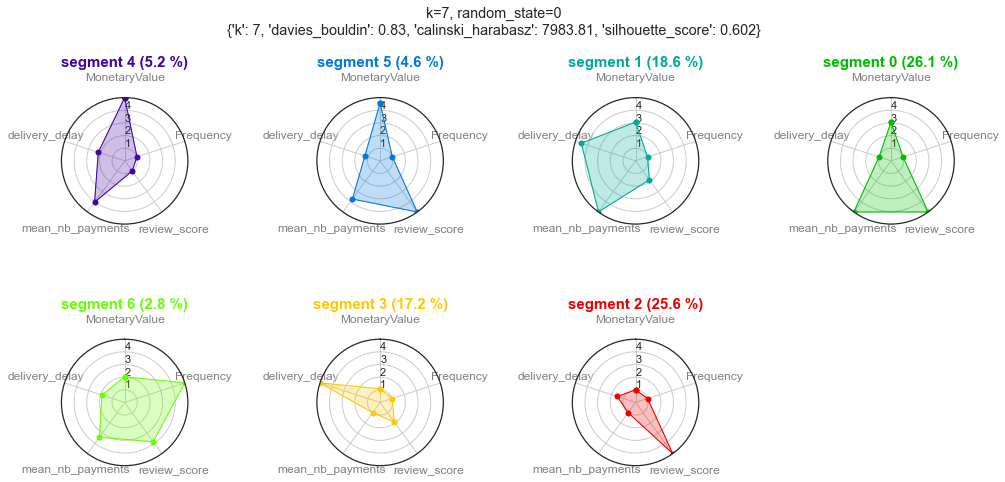

In [93]:
run_fit_spider(df_clients, features_5, k=7)


[1, 2, 3, 0]
"k=4,_random_state=0.png"


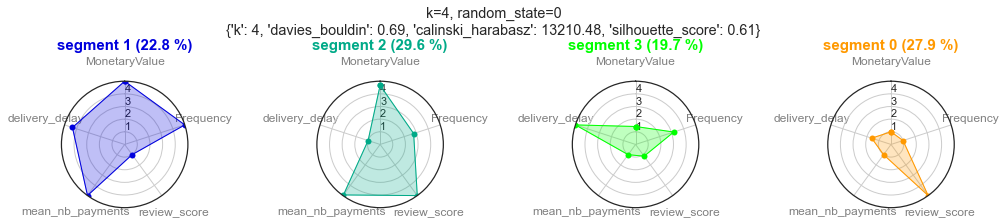

[3, 0, 1, 2]
"k=4,_random_state=1.png"


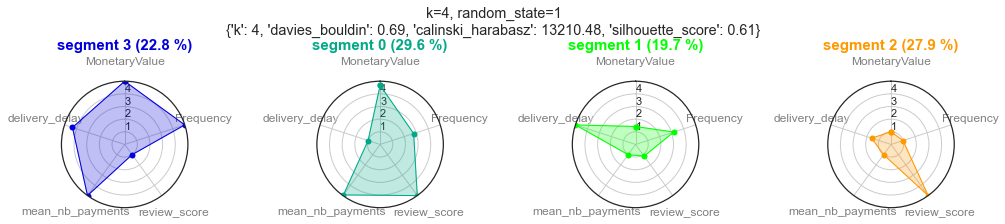

In [94]:
def find_segments(df: pd.DataFrame, features):
    scores = pd.DataFrame({})
    for k in range(4, 5):
        for i in range(0, 2):
            m, p = run_fit_spider(df, features, k=k, random_state=i)
            scores = scores.append(
                dict(**dict(random_state=i), **dict(m), **dict(p)), ignore_index=True)
            titre = f'k={k}, random_state={i}'
            plt.suptitle(f'{titre}\n{m}')
            to_png(titre)
            plt.show()
    return scores

scors=find_segments(df_clients, features_3)
# scors.to_csv('df_scores.csv')


[6, 2, 1, 5, 3, 4, 0]


({'k': 7,
  'davies_bouldin': 0.64,
  'calinski_harabasz': 15159.28,
  'silhouette_score': 0.663},
 {'seg 0': 5.47,
  'seg 1': 28.86,
  'seg 2': 16.17,
  'seg 3': 2.71,
  'seg 4': 4.49,
  'seg 5': 14.71,
  'seg 6': 27.58})

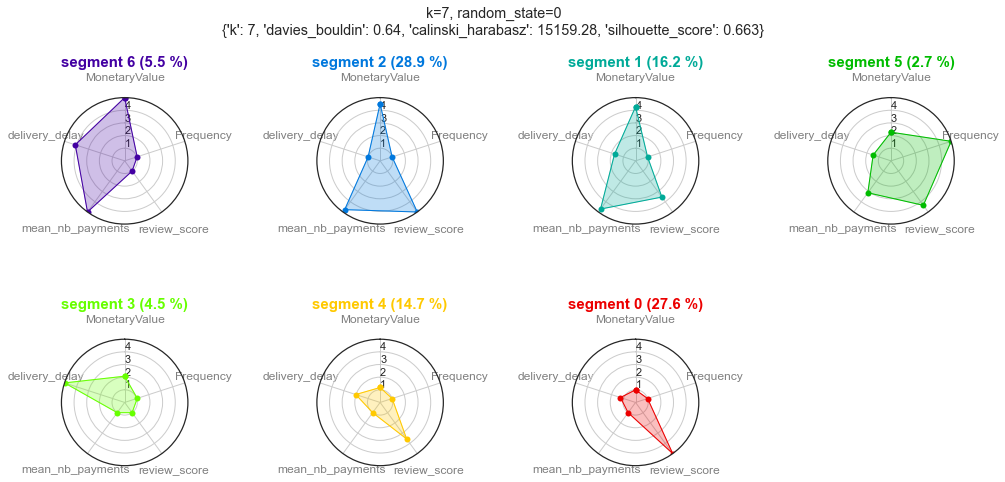

In [95]:
run_fit_spider(clients, features_3, k=7)


[4, 0, 3, 5, 1, 2]


({'k': 6,
  'davies_bouldin': 0.66,
  'calinski_harabasz': 13718.87,
  'silhouette_score': 0.642},
 {'seg 0': 5.47,
  'seg 1': 28.86,
  'seg 2': 16.17,
  'seg 3': 2.71,
  'seg 4': 19.21,
  'seg 5': 27.58})

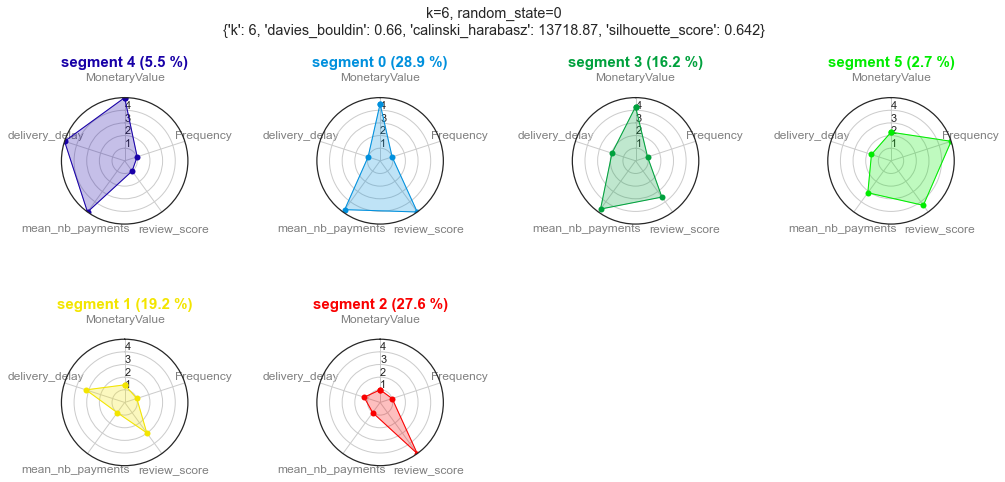

In [96]:
run_fit_spider(clients, features_3, k=6)


### Visualisation des clusters centers via Bubble plot


Text(0.5, 0.98, 'Essai 3 :  Bubble plot')

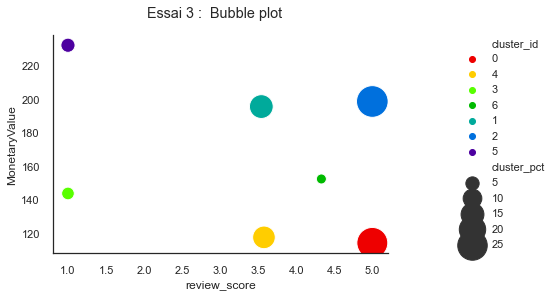

In [97]:
def plot_cluster_bubbles(df: pd.DataFrame, x_col=None, y_col=None, cluster_col=CLUSTER_COL, sizes_col='cluster_pct'):
    if 'MonetaryValue' in df.columns:
        hue_order = list(df.groupby(cluster_col)[
                         'MonetaryValue'].mean().sort_values().index)
        palette = 'nipy_spectral_r'
    else:
        hue_order = sorted(list(df[cluster_col].unique()))
        palette = None
    sns.scatterplot(data=df, x=x_col, y=y_col, size=sizes_col, hue=cluster_col,
                    hue_order=hue_order, palette=palette, sizes=(100, 1000))
    sns.despine()
    plt.legend(bbox_to_anchor=(1.5, 0.5), loc=5)


plot_cluster_bubbles(cluster_means, 'review_score', 'MonetaryValue')
plt.suptitle(f'{ESSAI_3} Bubble plot')


### Visualisation des clusters sur les composants principaux


pca feature labels : ['Frequency', 'MonetaryValue', 'Recency', 'mean_nb_payments', 'review_score', 'delivery_time', 'delivery_delay', 'distance_customer_seller', 'freight_percent', 'time_of_day', 'weekday', 'products_per_order']


Text(0.5, 0.98, 'Essai 3 :  Visualisation sur Composants Principales')

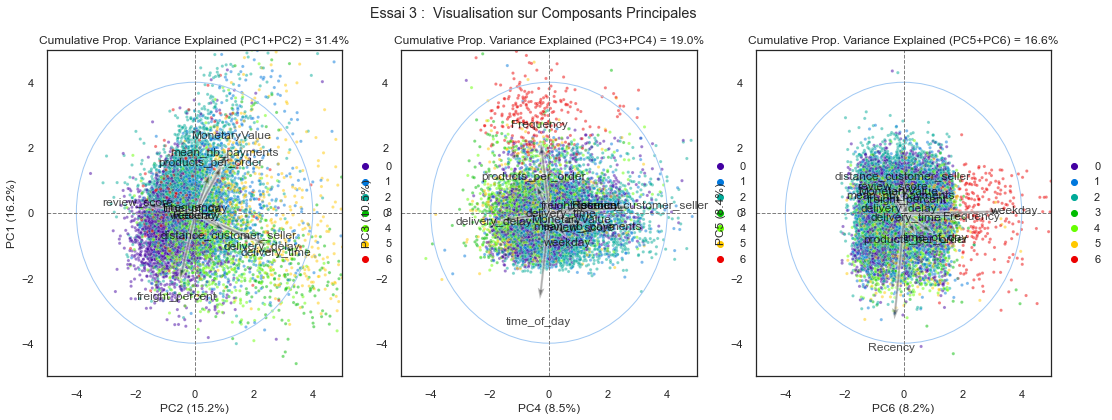

In [98]:
plot_clusters_on_pca(clients_clusters, axis_ranks=[(0, 1), (2, 3), (4, 5)])
plt.suptitle(f'{ESSAI_3} Visualisation sur Composants Principales')


### Visualisation t-SNE

La calculation t-SNE prend beaucoup de temps. On fait avec un échantillon de 5000 points aléatoires pour répresenter les groups

#### Hyperparamètres de t-SNE:
La **perplexity** est une mesure de nombre de neighbours qui attire chaque point
  - si on met perplexity trop pétit, on favorise l'information local, donc la sortie est avecbeaucoup de petit groupes
  - avec un perplexity > 30, on a tendance a prend plus de voisins en compte, favorisant l'information global

La valeur de perplexity a choisir dépend du **nombre de points**, le **preprocessing** avant t-SNE, et la nombre de clusters qu'on cherche

Donc, on met perplexity, sample_size, preprocessor comme (hyper)parametres

  - <https://stats.stackexchange.com/questions/399868/why-does-larger-perplexity-tend-to-produce-clearer-clusters-in-t-sne> 
- <https://towardsdatascience.com/explaining-k-means-clustering-5298dc47bad6>


"Essai_3_-__t-SNE_Visualisation_des_clusters_-_Quantile(uniform).png"


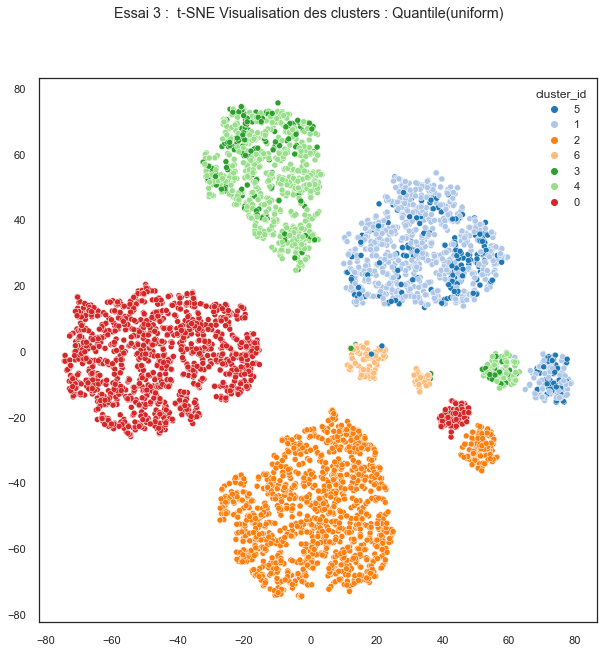

In [138]:
from sklearn.manifold import TSNE

pre_quant_uniform =QuantileTransformer(output_distribution='uniform', random_state=RANDOM_SEED)
pre_quant_normal =QuantileTransformer(output_distribution='normal', random_state=RANDOM_SEED)

def calc_tsne(df: pd.DataFrame, preprocessor=pre_quant_uniform, cluster_col=CLUSTER_COL,
    sample_size=5000, perplexity=30, random_state=RANDOM_SEED):
    """Calculate une visualisation de données basé sur preprocessing """
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('tsne', TSNE(n_components=2, perplexity=perplexity,
         verbose=0, init='pca',random_state=random_state))
    ])
    sample_size = min(sample_size, len(df))
    df_sample = df.sample(sample_size, random_state=random_state)
    if cluster_col in df_sample:
        df_sample[cluster_col]=df[cluster_col].astype('category')
    tsne = model.fit_transform(df_sample.select_dtypes('number'))
    return df_sample, tsne

def plot_tsne(df: pd.DataFrame, tsne, hue_col=CLUSTER_COL):
    """
    Visualise les clusters sur des 
    """
    hue_order = calc_cluster_order(df, cluster_col=hue_col)
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1],
                    hue=df[hue_col], hue_order=hue_order, cmap='nipy_spectral')

def run_fit_plot_tsne(df: pd.DataFrame, preprocessor=pre_quant_uniform, 
    cluster_col=CLUSTER_COL, hue_col=CLUSTER_COL,
 sample_size=5000, perplexity=30, random_state=RANDOM_SEED):
    """
    Fit t-SNE, puis visualise les clusters sur des 
    """
    sample_df,tsne=calc_tsne(df,preprocessor,cluster_col,sample_size,perplexity,random_state)
    plot_tsne(sample_df,tsne,hue_col)
    return sample_df, tsne

sample_df, tsne = run_fit_plot_tsne(clients_clusters, preprocessor=pre_quant_uniform)
plt.suptitle(f'{ESSAI_3} t-SNE Visualisation des clusters : Quantile(uniform)')
to_png()


In [137]:
sample_df

NameError: name 'sample_df' is not defined

"Essai_3_-__t-SNE_Visualisation_de_(k=7)_clusters_(Quantile(normal)).png"


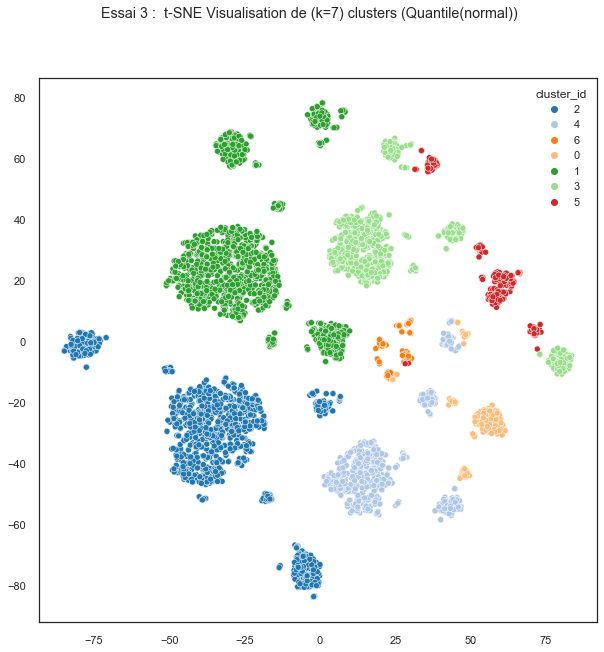

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans

k_choix=7
pre_quant_normal = QuantileTransformer(output_distribution='normal',random_state=RANDOM_SEED)
model_kmeans_quant_normal = Pipeline(steps=[
    ('preprocessor', pre_quant_normal),
    ('clf', KMeans(n_clusters=7, init='k-means++', random_state=RANDOM_SEED))
])

clusters_quant_normal, _=run_fit_model(df_clients,model_kmeans_quant_normal,k=k_choix)
plot_tsne(clusters_quant_normal, pre_quant_normal)
plt.suptitle(f'{ESSAI_3} t-SNE Visualisation de (k={k_choix}) clusters (Quantile(normal))')

to_png()

"Essai_3_-__t-SNE_Visualisation_de_(k=7)_clusters_fit_quantile(normal),_visual_(Quantile(uniform)).png"


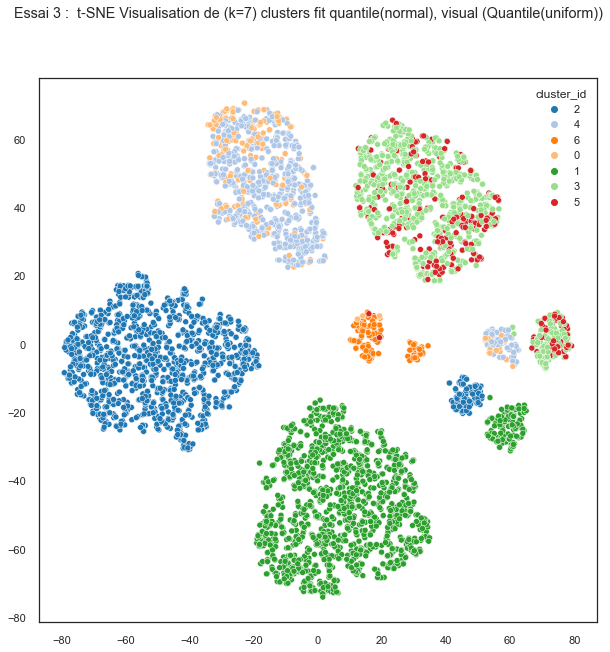

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
k_choix=7

pre_quant_uniform = QuantileTransformer(output_distribution='uniform',random_state=RANDOM_SEED)
model_kmeans_quant_uniform = Pipeline(steps=[
    ('preprocessor', pre_quant_uniform),
    ('clf', KMeans(n_clusters=k_choix, random_state=RANDOM_SEED))
])

clusters_quant_normal, _=run_fit_model(df_clients,model_kmeans_quant_normal,k=k_choix)
plot_tsne(clusters_quant_normal, pre_quant_uniform)
plt.suptitle(f'{ESSAI_3} t-SNE Visualisation de (k={k_choix}) clusters fit quantile(normal), visual (Quantile(uniform))')

to_png()

"Essai_3_-__t-SNE_Visualisation_de_(k=7)_clusters_fit_quantile(normal),_visual_(Quantile(uniform)).png"


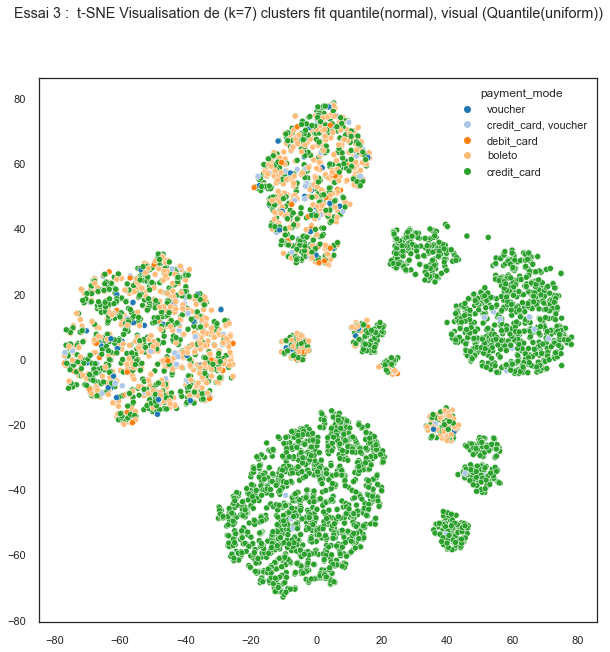

In [102]:
# clusters_quant_normal, _=run_fit_model(df_clients,model_kmeans_quant_normal,k=k_choix)
plot_tsne(clients_clusters, pre_quant_uniform,'payment_mode')
plt.suptitle(f'{ESSAI_3} t-SNE Visualisation de (k={k_choix}) clusters fit quantile(normal), visual (Quantile(uniform))')

to_png()

In [103]:
clusters_quant_normal.columns

Index(['customer_unique_id', 'dernier_achat', 'Frequency', 'MonetaryValue',
       'Recency', 'mean_nb_payments', 'review_score', 'delivery_time',
       'delivery_delay', 'distance_customer_seller', 'freight_percent',
       'payment_mode', 'favourite_category', 'time_of_day', 'weekday',
       'products_per_order', 'outlier', 'cluster_id'],
      dtype='object')

"Essai_3_-__t-SNE_Visualisation_de_(k=7)_clusters_fit_quantile(normal),_visual_(Quantile(uniform)).png"


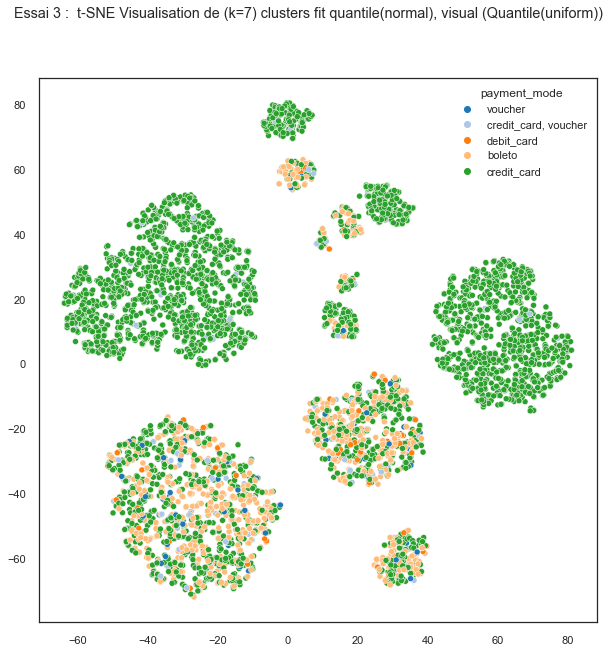

In [104]:
plot_tsne(clusters_quant_normal, pre_quant_uniform, cluster_col='payment_mode')
plt.suptitle(f'{ESSAI_3} t-SNE Visualisation de (k={k_choix}) clusters fit quantile(normal), visual (Quantile(uniform))')

to_png()

"Essai_3_-__t-SNE_Visualisation_des_clusters_(Quantile(normal)_+_PCA).png"


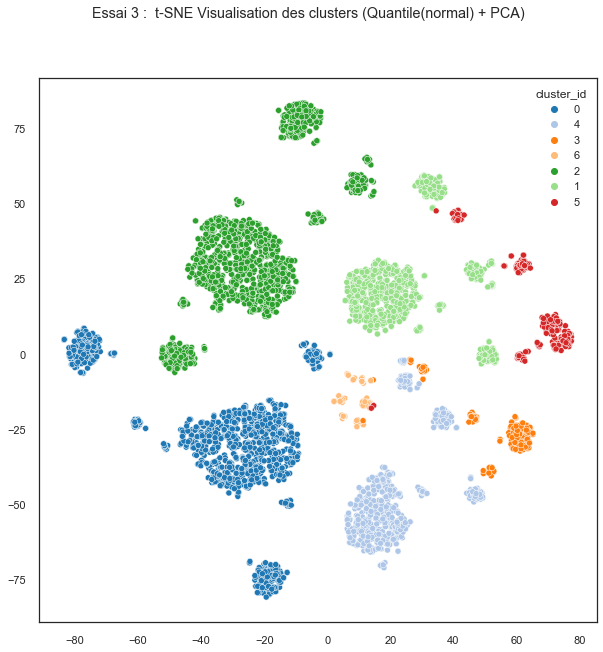

In [105]:
pre_quant_pca = Pipeline(steps=[
    ('scale', QuantileTransformer(
        output_distribution='normal', random_state=RANDOM_SEED)),
    ('pca', PCA())
])
model_kmeans_quant_pca = Pipeline(steps=[
    ('preprocessor', pre_quant_pca),
    ('clf', KMeans(n_clusters=7, random_state=RANDOM_SEED))
])

clusters_quant_pca, _=run_fit_model(df_clients,model_kmeans_quant_uniform,k=k_choix)
plot_tsne(clients_clusters, preprocessor=pca_preprocessor)
plt.suptitle(f'{ESSAI_3} t-SNE Visualisation des clusters (Quantile(normal) + PCA)')

to_png()


"Essai_3_-__t-SNE_Favourite_category_de_(k=7)_clusters_fit_quantile(normal),_visual_(Quantile(uniform)).png"


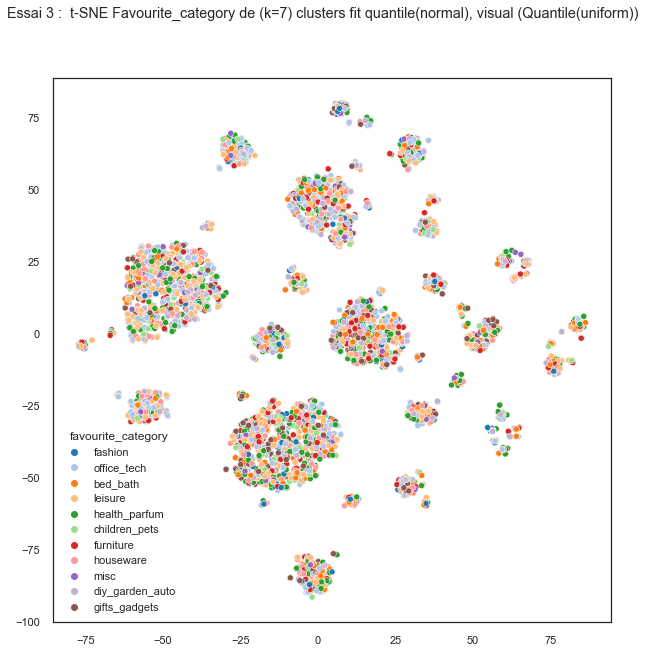

In [106]:
plot_tsne(clients_clusters, pca_preprocessor, cluster_col='favourite_category')
plt.suptitle(f'{ESSAI_3} t-SNE Favourite_category de (k={k_choix}) clusters fit quantile(normal), visual (Quantile(uniform))')

to_png()

In [107]:
clients_clusters.columns

Index(['customer_unique_id', 'dernier_achat', 'Frequency', 'MonetaryValue',
       'Recency', 'mean_nb_payments', 'review_score', 'delivery_time',
       'delivery_delay', 'distance_customer_seller', 'freight_percent',
       'payment_mode', 'favourite_category', 'time_of_day', 'weekday',
       'products_per_order', 'outlier', 'cluster_id'],
      dtype='object')

"Essai_3_-__t-SNE_Visualisation_des_clusters_(MinMaxScaler).png"


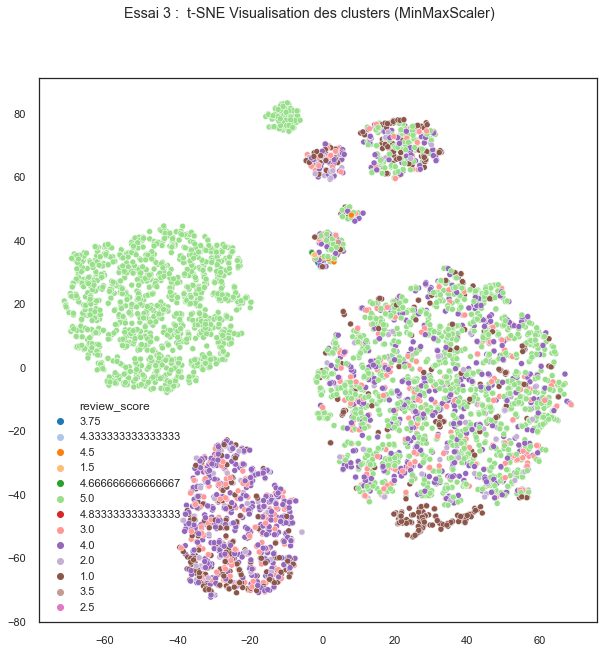

In [108]:
plot_tsne(clients_clusters,cluster_col='review_score')
plt.suptitle(f'{ESSAI_3} t-SNE Visualisation des clusters (MinMaxScaler)')

to_png()


On essaie plusieurs preprocessors

"Essai_3_-__t-SNE_Visualisation_des_clusters_(uniform).png"


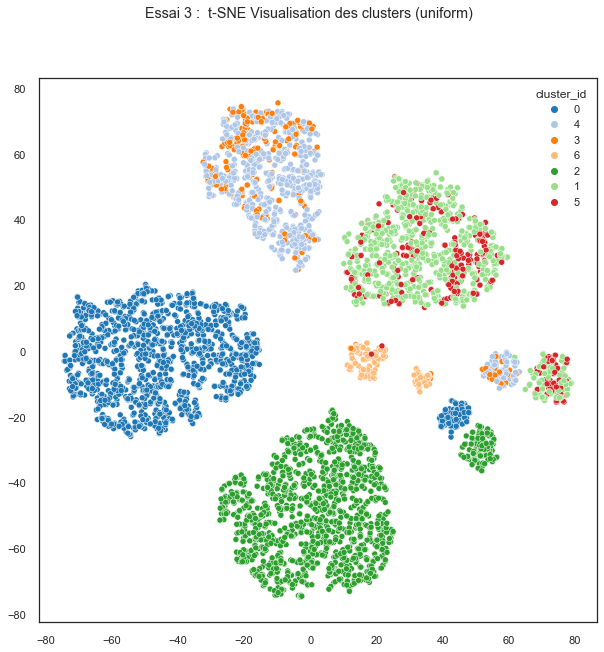

In [109]:
plot_tsne(clients_clusters,pre_quant_uniform)
plt.suptitle(f'{ESSAI_3} t-SNE Visualisation des clusters (uniform)')

to_png()

On voit que les clusters segment les clients de la façon suivant :

- 0 : haut valeur
- 1 : bas valeur, pas tres récent
- 2 : clients fréquents
- 3 : bas valeur, clients récents


Les clusters ci-dessus sont plus difficile à distinguer entre eux

- On peut mieux visualizer sur les premiers 2 principaux components de PCA ou t-SNE


### Interpreter les clusters


In [110]:
def run_kmeans_labels(df: pd.DataFrame, n_clusters=k_best):
    df = df.copy()
    if 'cluster_label' in df.columns:
        df = df.drop(columns='cluster_label')
    model = Pipeline(steps=[
        ('preprocessor', quantile_transformer),
        ('clf', KMeans(n_clusters=n_clusters))
    ])
    model.fit(df)
    clf = model.named_steps['clf']
    df['cluster_label'] = clf.labels_
    return df


clients_rfm_scaled = clients[features_3].pipe(run_kmeans_labels, n_clusters=6)

clients_rfm_scaled.groupby('cluster_label').mean()


MonetaryValue  Frequency  review_score  mean_nb_payments  \
cluster_label                                                             
0                     190.88       1.00          3.54              4.65   
1                     113.03       1.00          5.00              1.00   
2                     196.46       1.00          5.00              4.70   
3                     207.96       1.01          1.00              4.93   
4                     122.31       1.00          2.97              1.00   
5                     143.07       2.10          4.35              3.08   

               delivery_delay  
cluster_label                  
0                      -11.10  
1                      -12.47  
2                      -13.20  
3                       -4.48  
4                       -8.36  
5                      -11.83

### Essai 4 : Trouver les meilleurs indicateurs pour une segmentation en 8 clusters


In [111]:
from sklearn.metrics import silhouette_score, davies_bouldin_score


def find_best_features(data, k_range=range(2, 9), maxvars=8,
                       sample_size=5000, scoring='silhouette', kmeans_kwargs=dict()):
    if CLUSTER_COL in data.columns:
        data = data.drop(CLUSTER_COL, axis=1)
    num_cols = data.select_dtypes('number').columns
    scaler = QuantileTransformer(output_distribution='normal')
    df = pd.DataFrame(scaler.fit_transform(data[num_cols].sample(
        sample_size, random_state=RANDOM_SEED)), columns=num_cols)

    results_for_each_k = []
    vars_for_each_k = {}
    # output: heatmap of k in rows, n_var in columns, score as value
    # select best silhouette score for each k
    best_scores_df = pd.DataFrame(
        [], columns={'k', 'n_var', 'score', 'best_vars'})
    all_scores_df = pd.DataFrame([], columns={'k', 'n_var'})
    for k in k_range:

        selected_variables = []
        cols = list(df.columns)
        results = []
        while len(selected_variables) < maxvars:
            results = []
            for col in cols:
                # keep feature with best silhouette/davies_bouldin score, try each remaining column
                scols = [*selected_variables, *[col]]
                clf = KMeans(n_clusters=k, random_state=RANDOM_SEED,**kmeans_kwargs)
                clf.fit(df[scols])
                scores = dict(
                    k=k,
                    n_var=len(scols),
                    cols=[*scols],
                    inertia=clf.inertia_,
                    davies_bouldin=davies_bouldin_score(
                        df[scols], clf.labels_),
                    silhouette=silhouette_score(df[scols], clf.labels_)
                )
                all_scores_df = all_scores_df.append(scores, ignore_index=True)
                if scoring == 'silhouette':
                    score = scores['silhouette']
                else:
                    score = scores['davies_bouldin']
                results.append(score)

            if scoring == 'silhouette':
                selected_var = cols[np.argmax(results)]
                best_score = np.max(results)
            else:
                # davies_bouldin
                selected_var = cols[np.argmin(results)]
                best_score = np.min(results)

            selected_variables.append(selected_var)
            best_result = {'k': k, 'n_var': len(
                selected_variables), 'score': best_score, 'best_vars': [*selected_variables]}
            best_scores_df = best_scores_df.append(
                best_result, ignore_index=True)
            cols.remove(selected_var)
        if scoring == 'silhouette':
            results_for_each_k.append(max(results))
        else:
            results_for_each_k.append(min(results))
        print(f'k={k} : variables = {selected_variables}')
        vars_for_each_k[k] = selected_variables

    if scoring == 'silhouette':
        best_k_ = np.argmax(results_for_each_k)+min(k_range)
    else:
        best_k_ = np.argmin(results_for_each_k)+min(k_range)
    # you can also force a value for k
    # best_k=3
    selected_variables = vars_for_each_k[best_k_]
    return best_k_, selected_variables, best_scores_df, all_scores_df


#### Davies Bouldin scores


In [112]:

best_k, best_features, scores_df, results_df = find_best_features(
    clients, k_range=range(5, 8), maxvars=5, scoring='davies_bouldin')
kmeans = KMeans(n_clusters=best_k)
kmeans.fit(clients[best_features])
clients[CLUSTER_COL] = kmeans.predict(clients[best_features])


C:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.


k=5 : variables = ['Frequency', 'review_score', 'products_per_order', 'freight_percent', 'MonetaryValue']


C:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (6). Possibly due to duplicate points in X.


k=6 : variables = ['Frequency', 'review_score', 'Recency', 'products_per_order', 'freight_percent']


C:\Users\mc\anaconda3\envs\OC_3\lib\site-packages\ipykernel_launcher.py:31: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (7). Possibly due to duplicate points in X.


k=7 : variables = ['Frequency', 'review_score', 'time_of_day', 'delivery_time', 'products_per_order']


best_vars  \
0                                                                     [Frequency]   
1                                                       [Frequency, review_score]   
2                                   [Frequency, review_score, products_per_order]   
3                  [Frequency, review_score, products_per_order, freight_percent]   
4   [Frequency, review_score, products_per_order, freight_percent, MonetaryValue]   
5                                                                     [Frequency]   
6                                                       [Frequency, review_score]   
7                                              [Frequency, review_score, Recency]   
8                          [Frequency, review_score, Recency, products_per_order]   
9         [Frequency, review_score, Recency, products_per_order, freight_percent]   
10                                                                    [Frequency]   
11                                                      [Frequency, review_score]   
12                                         [Frequency, review_score, time_of_day]   
13                          [Frequency, review_score, time_of_day, delivery_time]   
14      [Frequency, review_score, time_of_day, delivery_time, products_per_order]   

    score  k n_var  
0    0.00  5     1  
1    0.12  5     2  
2    0.40  5     3  
3    0.48  5     4  
4    0.57  5     5  
5    0.00  6     1  
6    0.08  6     2  
7    0.42  6     3  
8    0.58  6     4  
9    0.62  6     5  
10   0.00  7     1  
11   0.11  7     2  
12   0.43  7     3  
13   0.50  7     4  
14   0.70  7     5

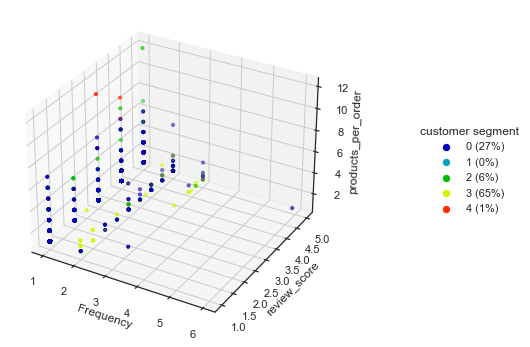

In [113]:


# features=best_features[:3]+[CLUSTER_COL]
features=[*best_features[:3],*[CLUSTER_COL]]
plot_3d(clients[features])
scores_df


In [114]:
db_scores = pd.crosstab(
    index=scores_df['k'], columns=scores_df['n_var'], values=scores_df['score'], aggfunc='mean')
db_scores.style.background_gradient(cmap='coolwarm', axis=None)


<AxesSubplot:xlabel='n_var', ylabel='score'>

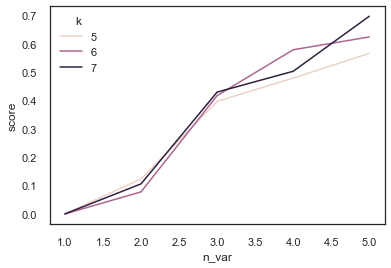

In [115]:
sns.lineplot(data=scores_df, x='n_var', y='score', hue='k')


In [116]:
db = results_df.groupby(['k', 'n_var']).agg({
    'davies_bouldin': 'min',
    'silhouette': 'max',
}).reset_index()
db


k  n_var  davies_bouldin  silhouette
0   5      1            0.00        1.00
1   5      2            0.12        0.99
2   5      3            0.40        0.90
3   5      4            0.48        0.74
4   5      5            0.57        0.66
5   6      1            0.00        1.00
6   6      2            0.08        0.99
7   6      3            0.42        0.94
8   6      4            0.58        0.76
9   6      5            0.62        0.67
10  7      1            0.00        1.00
11  7      2            0.11        0.99
12  7      3            0.43        0.96
13  7      4            0.50        0.72
14  7      5            0.70        0.64

##### Davies-Bouldin Cross-tab (n_var, k)


In [117]:
db_scores = pd.crosstab(
    index=db['k'], columns=db['n_var'], values=db['davies_bouldin'], aggfunc='mean')
db_scores.style.background_gradient(cmap='coolwarm', axis=None)


##### Silhouette Cross-tab (n_var, k)


In [118]:
silhouette_scores = pd.crosstab(
    index=db['k'], columns=db['n_var'], values=db['silhouette'], aggfunc='mean')
silhouette_scores.style.background_gradient(cmap='coolwarm', axis=None)


In [119]:
results_df[(results_df['n_var'] == 5) & (results_df['k'] == 7)]


k n_var  \
142  7     5   
143  7     5   
144  7     5   
145  7     5   
146  7     5   
147  7     5   
148  7     5   
149  7     5   

                                                                                cols  \
142             [Frequency, review_score, time_of_day, delivery_time, MonetaryValue]   
143                   [Frequency, review_score, time_of_day, delivery_time, Recency]   
144          [Frequency, review_score, time_of_day, delivery_time, mean_nb_payments]   
145            [Frequency, review_score, time_of_day, delivery_time, delivery_delay]   
146  [Frequency, review_score, time_of_day, delivery_time, distance_customer_seller]   
147           [Frequency, review_score, time_of_day, delivery_time, freight_percent]   
148                   [Frequency, review_score, time_of_day, delivery_time, weekday]   
149        [Frequency, review_score, time_of_day, delivery_time, products_per_order]   

     davies_bouldin  inertia  silhouette  
142            0.95 17199.93        0.37  
143            0.90 16954.51        0.40  
144            0.70 21930.14        0.61  
145            0.97 17390.14        0.37  
146            0.84 16416.46        0.41  
147            0.95 17403.48        0.37  
148            0.78 29581.24        0.53  
149            0.70 19087.70        0.64

[delivery_delay, products_per_order, mean_nb_payments, MonetaryValue, freight_percent]

'delay_last_order',
'review_score_mean_per_order', 'order_value_mean',
'installments_per_order_mean',
'num_products', 'price_mean',
'num_products_per_order_mean'


In [120]:
scores_df[scores_df['n_var'] == 4]


best_vars  score  k  \
3   [Frequency, review_score, products_per_order, freight_percent]   0.48  5   
8           [Frequency, review_score, Recency, products_per_order]   0.58  6   
13           [Frequency, review_score, time_of_day, delivery_time]   0.50  7   

   n_var  
3      4  
8      4  
13     4

In [121]:
scores_df[scores_df['n_var'] == 5]


best_vars  \
4   [Frequency, review_score, products_per_order, freight_percent, MonetaryValue]   
9         [Frequency, review_score, Recency, products_per_order, freight_percent]   
14      [Frequency, review_score, time_of_day, delivery_time, products_per_order]   

    score  k n_var  
4    0.57  5     5  
9    0.62  6     5  
14   0.70  7     5

In [122]:
scores_df[scores_df['n_var'] == 6]


Empty DataFrame
Columns: [best_vars, score, k, n_var]
Index: []

### Categories sur les clusters

## Essaie 4 : Kprototype

La visualisation t-SNE semble montre que les types de paiement peut aider faire du clustering

# Autres méthodes de clustering

- <https://scikit-learn.org/stable/modules/clustering.html>


## Agglomerative Clustering (Clustering Hiérarchique)


In [123]:
from scipy.cluster.hierarchy import dendrogram


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [124]:
def filtered_dict(d, filter_string):
    result = {k: v for (k, v) in d.items() if filter_string in k}
    return result


def get_named_step_params(pipeline, named_step):
    params_ = pipeline.get_params()
    return filtered_dict(params_, named_step)


In [126]:
from sklearn.cluster import AgglomerativeClustering

sample_size= min(10000,len(clients))
clients_sample = clients.sample(sample_size, random_state=RANDOM_SEED)

model_cah = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(
        output_distribution='normal', random_state=RANDOM_SEED)),
    # setting distance_threshold=0 ensures we compute the full tree.
    # ('clf', AgglomerativeClustering(n_clusters=None, distance_threshold=0))
    ('clf', AgglomerativeClustering(compute_distances=True))
])
print(get_named_step_params(model_cah, 'clf'))


{'clf': AgglomerativeClustering(compute_distances=True), 'clf__affinity': 'euclidean', 'clf__compute_distances': True, 'clf__compute_full_tree': 'auto', 'clf__connectivity': None, 'clf__distance_threshold': None, 'clf__linkage': 'ward', 'clf__memory': None, 'clf__n_clusters': 2}


{'clf': AgglomerativeClustering(compute_distances=True, n_clusters=7), 'clf__affinity': 'euclidean', 'clf__compute_distances': True, 'clf__compute_full_tree': 'auto', 'clf__connectivity': None, 'clf__distance_threshold': None, 'clf__linkage': 'ward', 'clf__memory': None, 'clf__n_clusters': 7}
7
['0', '1', '2', '3', '4', '5', '6']


Text(0.5, 0.98, 'agglomerative')

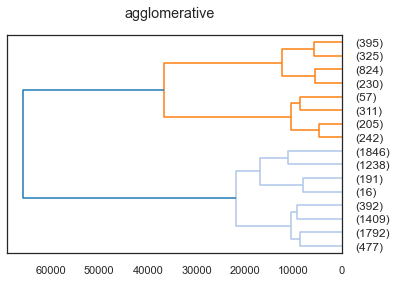

In [128]:
def run_agglomerative(df: pd.DataFrame, model=model_cah, n_clusters=5, linkage='average'):
    params = {'clf__linkage': linkage, 'clf__n_clusters': n_clusters}
    model.set_params(**params)
    print(get_named_step_params(model, 'clf'))
    model.fit(df.select_dtypes('number'))
    clf: AgglomerativeClustering = model.named_steps['clf']
    cluster_labels = pd.Series(clf.fit_predict(
        df.select_dtypes('number')), dtype=str)
    print(cluster_labels.nunique())
    print(sorted(list(cluster_labels.unique())))
    plot_dendrogram(model=clf, truncate_mode="level", p=3, orientation='left')
    df_clusters_labels = pd.DataFrame({CLUSTER_COL: cluster_labels},
                                      index=df.index).astype('object')
    # cluster_centers=clf.cluster_centers_
    df_clusters = df.select_dtypes('number').pipe(
        drop_cluster_labels).join(df_clusters_labels)
    # print(df_clusters.groupby(CLUSTER_COL).mean(
    # ).sort_values(by=['MonetaryValue']))
    return df_clusters


client_clusters = run_agglomerative(
    clients_sample,
     model_cah, n_clusters=7, linkage='ward')
plt.suptitle('agglomerative')


In [130]:
print(client_clusters[CLUSTER_COL].value_counts())
group_clusters(clients_clusters)


1    432
2    222
6    137
5    111
0     83
3     67
4     21
Name: cluster_id, dtype: int64


cluster_id  cluster_size  cluster_pct  Frequency  MonetaryValue  Recency  \
0          5           567         5.67       1.01         232.26   281.73   
1          2          2876        28.76       1.00         198.62   287.67   
2          1          1616        16.16       1.00         195.57   292.45   
3          6           279         2.79       2.11         152.27   271.71   
4          3           453         4.53       1.01         143.60   274.91   
5          4          1464        14.64       1.00         117.35   285.05   
6          0          2745        27.45       1.00         114.02   281.76   

   mean_nb_payments  review_score  delivery_time  delivery_delay  \
0              5.06          1.00          21.06           -3.56   
1              4.70          5.00          10.57          -13.20   
2              4.66          3.54          13.21          -11.02   
3              3.18          4.33          11.01          -12.23   
4              1.00          1.00          21.52           -1.81   
5              1.00          3.58          12.65          -10.32   
6              1.00          5.00           9.74          -12.48   

   distance_customer_seller  freight_percent  time_of_day  weekday  \
0                    696.33             0.15        14.65     2.82   
1                    645.39             0.17        14.94     2.80   
2                    660.71             0.17        15.12     2.82   
3                    512.35             0.18        14.38     2.85   
4                    646.32             0.22        14.60     2.79   
5                    554.82             0.22        14.70     2.69   
6                    533.46             0.23        14.79     2.72   

   products_per_order                customer_unique_id        dernier_achat  \
0                1.35  ac0dbedf05a8aba4b1e0228ebcbb3338  2017-09-15 14:29:40   
1                1.12  ce8306009970275b42de3d5330dd8849  2017-11-08 15:02:42   
2                1.18  838553dacf830190d6dbe6e96ecbb5c4  2018-07-23 18:08:41   
3                1.24  e0836a97eaae86ac4adc26fbb334a527  2017-07-17 22:44:24   
4                1.27  16534282c820ca754b8de47754bb6d1a  2017-12-19 19:34:25   
5                1.13  97cf3aefd84c788d3c579abe1915b6e0  2017-05-12 10:43:42   
6                1.09  363c8ecca5b19e58d8cc3fa055d76e08  2018-07-25 08:58:35   

  payment_mode favourite_category outlier  
0  credit_card           bed_bath      no  
1  credit_card      health_parfum      no  
2  credit_card        office_tech      no  
3  credit_card        office_tech      no  
4       boleto        office_tech      no  
5  credit_card        office_tech      no  
6  credit_card        office_tech      no

pca feature labels : ['MonetaryValue', 'Frequency', 'review_score', 'mean_nb_payments', 'delivery_delay']


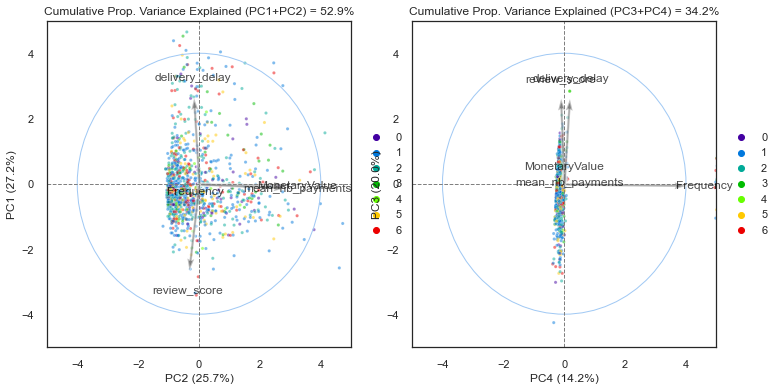

In [131]:
# palette= sns.color_palette('nipy_spectral_r', n_colors=9).as_hex()
cols=[*features_3,CLUSTER_COL]
plot_clusters_on_pca(client_clusters[cols],axis_ranks=AXIS_RANKS_0_3)


1    8617
0     943
2     281
6     106
5       1
4       1
3       1
dtype: int64


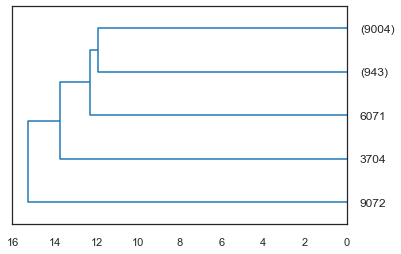

In [132]:
def run_fit_average_linkage(df: pd.DataFrame, model=model_cah, k=7):
    params = {'clf__linkage': 'average','clf__n_clusters': k}
    model.set_params(**params)
    model.fit(df.select_dtypes('number'))
    clf: AgglomerativeClustering = model.named_steps['clf']
    plot_dendrogram(model=clf, truncate_mode="level", p=3, orientation='left')
    print(pd.Series(clf.labels_).value_counts())


run_fit_average_linkage(clients_sample, model_cah)


## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)


 0    2872
 2    2744
 1    2147
 3    1905
-1     282
dtype: int64
[0, 1, -1, 3, 2]


{'seg 0': 28.86, 'seg 1': 21.58, 'seg 2': 2.83, 'seg 3': 19.15, 'seg 4': 27.58}

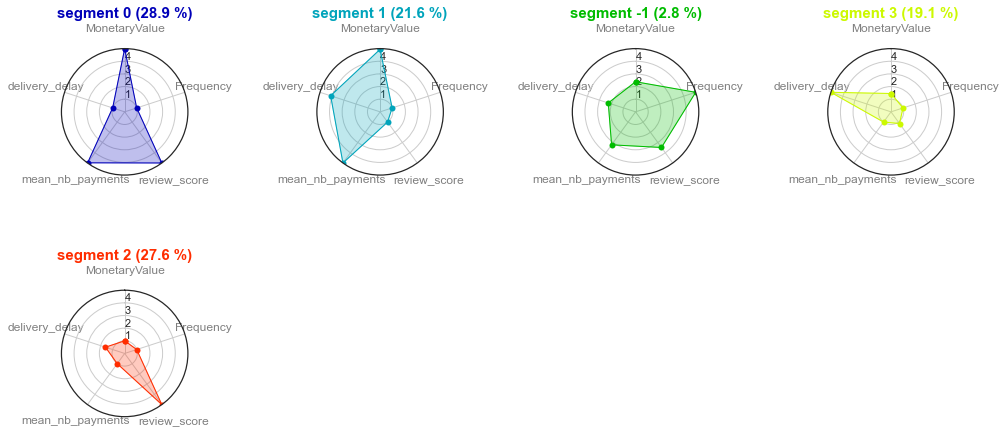

In [135]:
from sklearn.cluster import DBSCAN

model_dbscan = Pipeline(steps=[
    ('preprocessor', QuantileTransformer(output_distribution='normal')),
    ('clf', DBSCAN(eps=4, min_samples=200))
])


def run_fit_labels(df: pd.DataFrame, model=model_dbscan, features=FEATURES):
    df=df.copy()
    model.fit(df[features])
    clf = model.named_steps['clf']
    print(pd.Series(clf.labels_).value_counts())
    df[CLUSTER_COL]=clf.labels_
    return df

clients_sample=clients_sample
clusters=run_fit_labels(clients_sample, model_dbscan)
cluster_means=group_clusters(clusters)
plot_spider(cluster_means, features=features_3)